In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image

from skimage.metrics import structural_similarity as ssim

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.preprocessing import LabelEncoder

## 0 - Tests

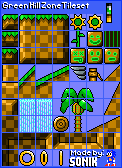

In [3]:
image_path = "generalmapsheet.png"
image = Image.open(image_path)
image

In [4]:
width, height = image.size
width, height

(122, 168)

In [5]:
image.crop((2, 14, 18, 30))

In [6]:
object_size = 16
intersect_d = 1
border_d = 2
up_d = 14

## 1 - Split the general mapsheet

Sprite are 16x16

for i in range(9):
    for j in range(7):
        sprite = image.crop((border_d + intersect_d * j + object_size * j, up_d + i * object_size + intersect_d * i, border_d + intersect_d * (j) + object_size * (j+1), up_d + object_size * (i + 1) + intersect_d * i))
        sprite.save(f'test/test_{i}_{j}.png')
        

## 2 - Split each green hill map

Make a comparison with 16 to 16.

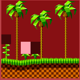

In [7]:
image_path = "GreenHillZone_Sprite/green_hill_map_1.png"
image = Image.open(image_path)
image

In [8]:
width, height = image.size
width, height

(80, 80)

Image will then be splitted in 5**2 parts

In [9]:
output_dir = "GreenHillZone_Tiles"
os.makedirs(output_dir, exist_ok=True)

for i in range(1, 56):
    image_path = f"GreenHillZone_Sprite/green_hill_map_{i}.png"
    image = Image.open(image_path)
    
    tile_size = 16  
    
    index = 0  # Tile counter

    # Loop through the 80x80 image in 16x16 steps
    for row in range(0, 80, tile_size):
        for col in range(0, 80, tile_size):
            # Crop the 16x16 tile
            tile = image.crop((col, row, col + tile_size, row + tile_size))

            tile_folder = os.path.join(output_dir, f"map_{i}")
            os.makedirs(tile_folder, exist_ok=True)  # Ensure the directory exists
            
            tile_path = os.path.join(tile_folder, f"tile_{index}.png")
            tile.save(tile_path)

            index += 1

## 3 - Match the sprites

### a - MSE method 

In [177]:
def mse(image1, image2):
    """Compute Mean Squared Error between two images."""
    arr1 = np.array(image1)
    arr2 = np.array(image2)
    return np.mean((arr1 - arr2) ** 2)

In [178]:
sprite_dir = "general_map_sprite"
sprite_images = {}

for sprite_file in os.listdir(sprite_dir):
    sprite_path = os.path.join(sprite_dir, sprite_file)
    if sprite_file.endswith((".png", ".jpg", ".jpeg")):
        sprite = Image.open(sprite_path).convert("RGB")  # Ensure consistent color mode
        sprite_images[sprite_file] = sprite

In [179]:
def show_image_comparison(tile, best_sprite, mse_score, message="MSE"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(tile)
    axes[0].set_title("Tile Image")
    axes[0].axis("off")

    # Load the best matching sprite for display
    best_sprite_img = Image.open(os.path.join(sprite_dir, best_sprite)).convert("RGB")
    axes[1].imshow(best_sprite_img)
    axes[1].set_title(f"Best Match: {best_sprite}\n{message}: {mse_score:.2f}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

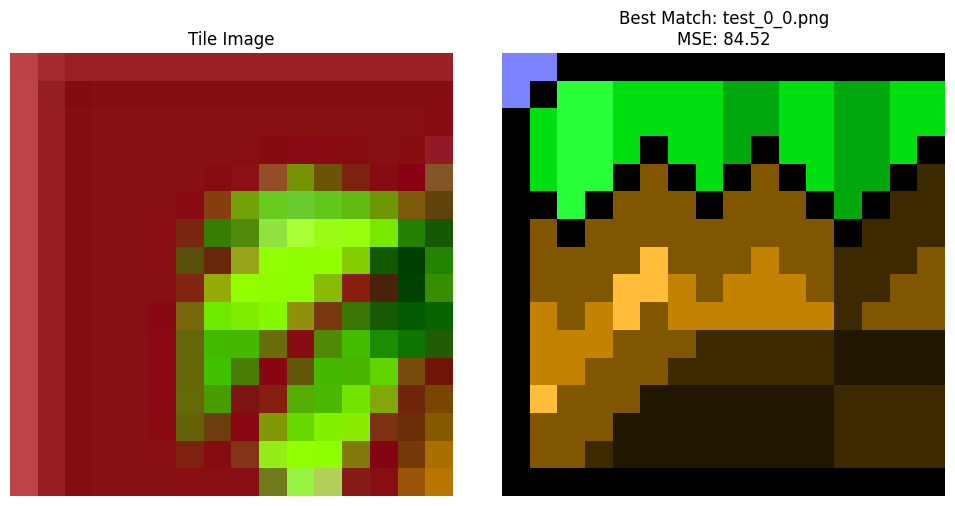

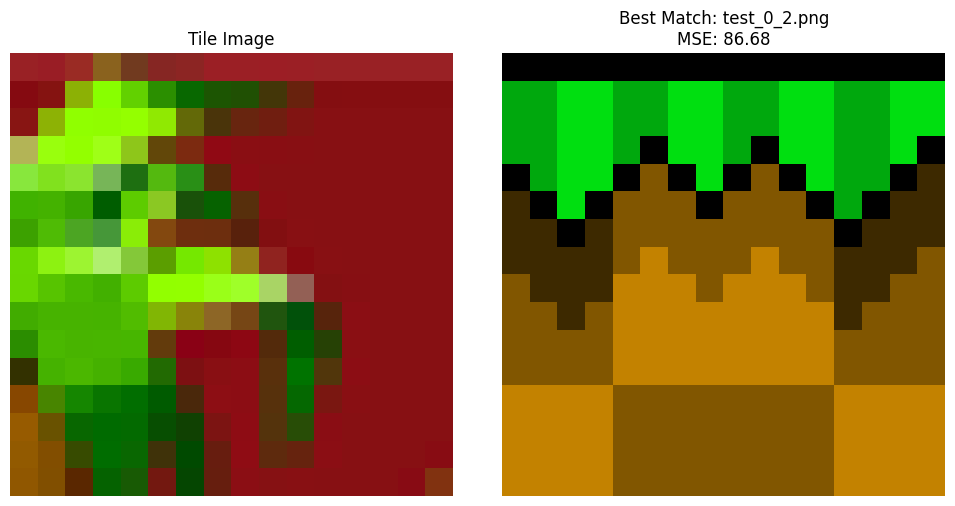

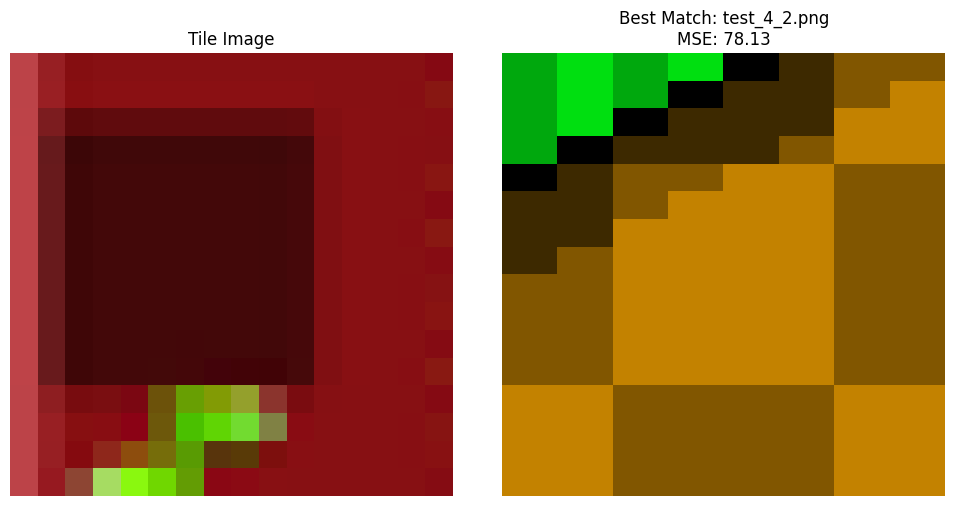

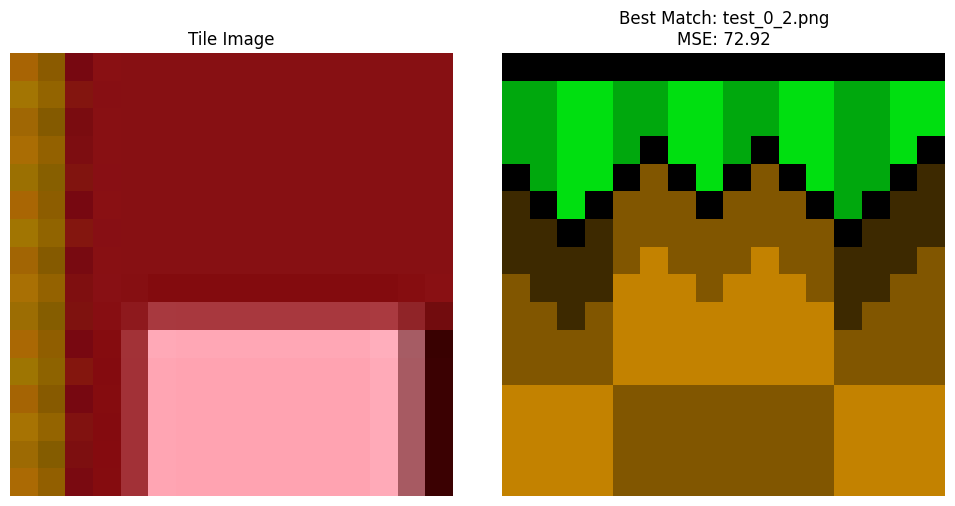

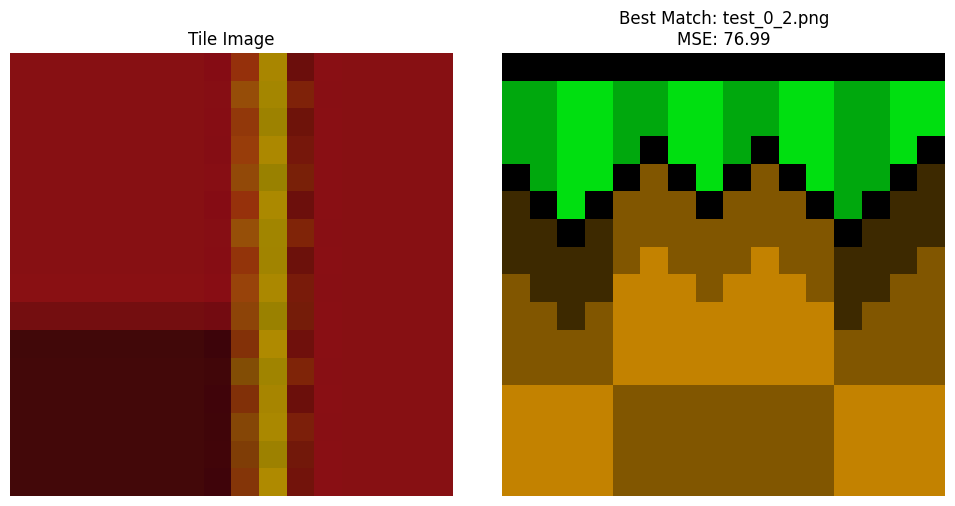

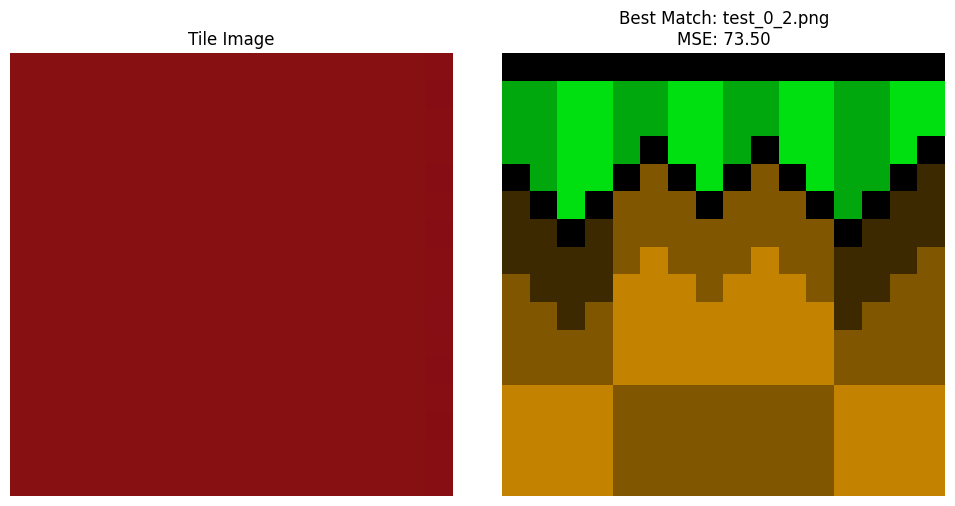

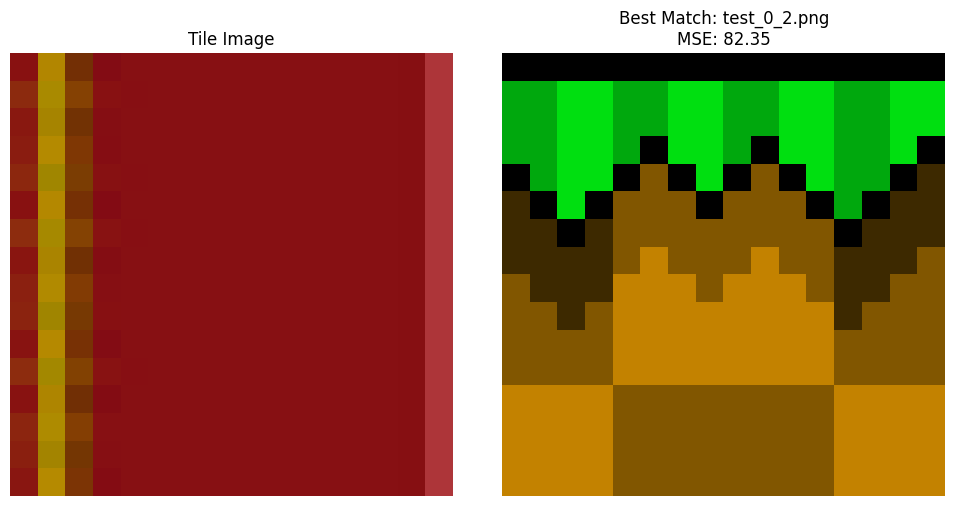

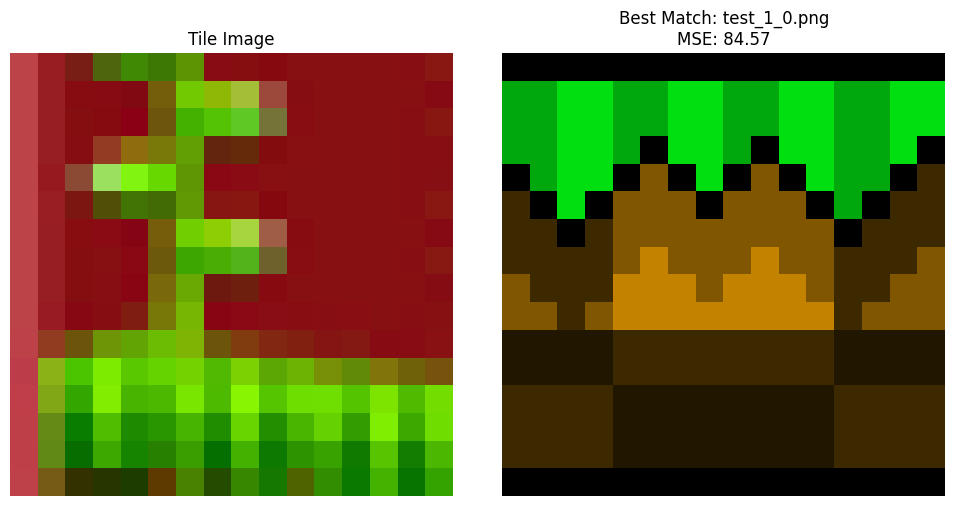

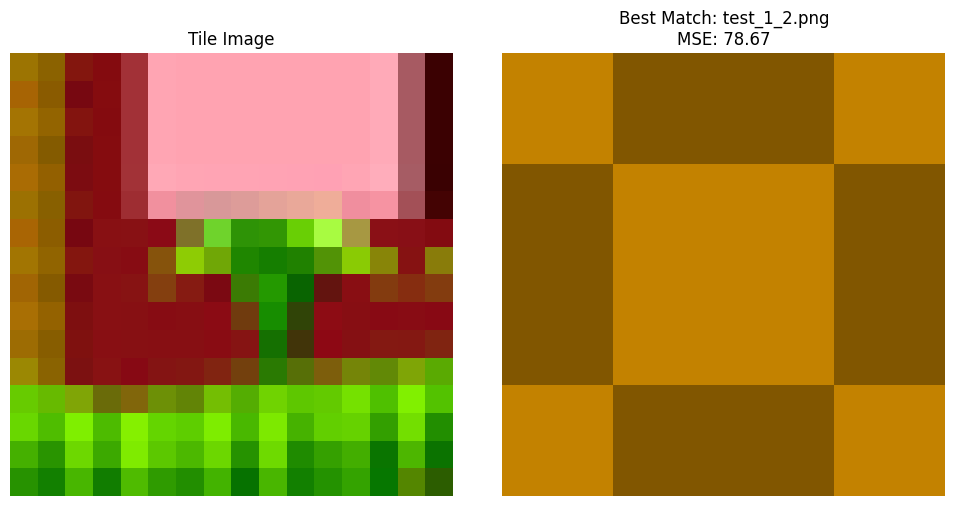

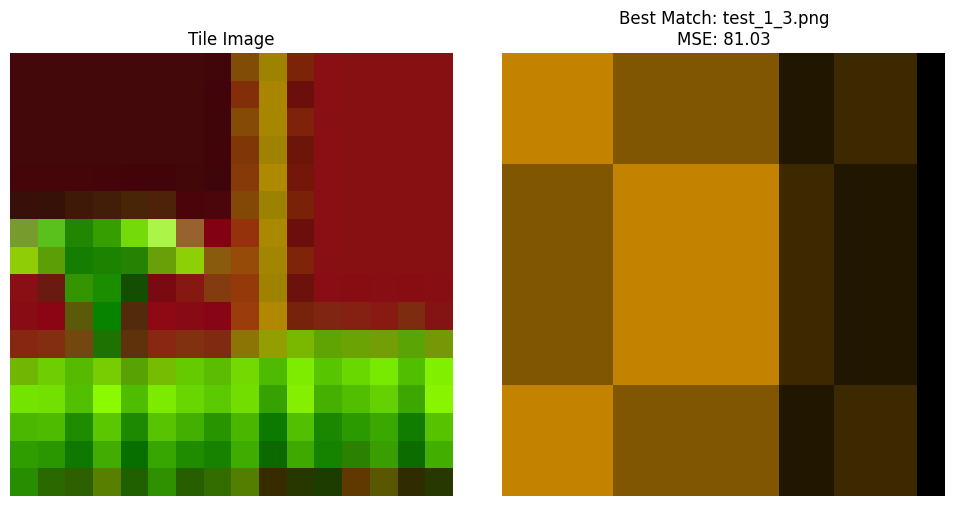

In [180]:
# Matching process
tile_dir = "GreenHillZone_Tiles"
results = []
cpt = 0

for map_folder in os.listdir(tile_dir):
    map_path = os.path.join(tile_dir, map_folder)
    if not os.path.isdir(map_path):
        continue

    for tile_file in os.listdir(map_path):
        tile_path = os.path.join(map_path, tile_file)

        if not tile_file.endswith((".png", ".jpg", ".jpeg")):
            continue

        tile = Image.open(tile_path).convert("RGB")

        # Find the closest match using MSE
        mse_scores = {
            sprite_name: mse(tile, sprite_img)
            for sprite_name, sprite_img in sprite_images.items()
        }

        best_match = min(mse_scores, key=mse_scores.get)
        best_score = mse_scores[best_match]

        results.append(
            {
                "map_tile": f"{map_folder}/{tile_file}",
                "best_match_sprite": best_match,
                "mse_score": best_score,
            }
        )

        # Display the comparison
        if cpt < 10:
            show_image_comparison(tile, best_match, best_score)
            cpt += 1

In [181]:
df_results = pd.DataFrame(results)

df_results.to_excel("mse_tile_matching_results.xlsx", index=False)

In [182]:
df_results

,map_tile,best_match_sprite,mse_score
0,map_1/tile_0.png,test_0_0.png,84.518229
1,map_1/tile_1.png,test_0_2.png,86.679688
2,map_1/tile_10.png,test_4_2.png,78.134115
3,map_1/tile_11.png,test_0_2.png,72.916667
4,map_1/tile_12.png,test_0_2.png,76.992188
...,...,...,...
1370,map_9/tile_5.png,test_0_1.png,75.158854
1371,map_9/tile_6.png,test_4_1.png,70.592448
1372,map_9/tile_7.png,test_7_3.png,68.160156
1373,map_9/tile_8.png,test_7_1.png,65.165365


### b - Structural Similarity Index (SSIM)

pip install scikit-image

In [183]:
def compute_ssim(image1, image2):
    arr1 = np.array(image1.convert("L"))  # Convert to grayscale
    arr2 = np.array(image2.convert("L"))
    return ssim(arr1, arr2)

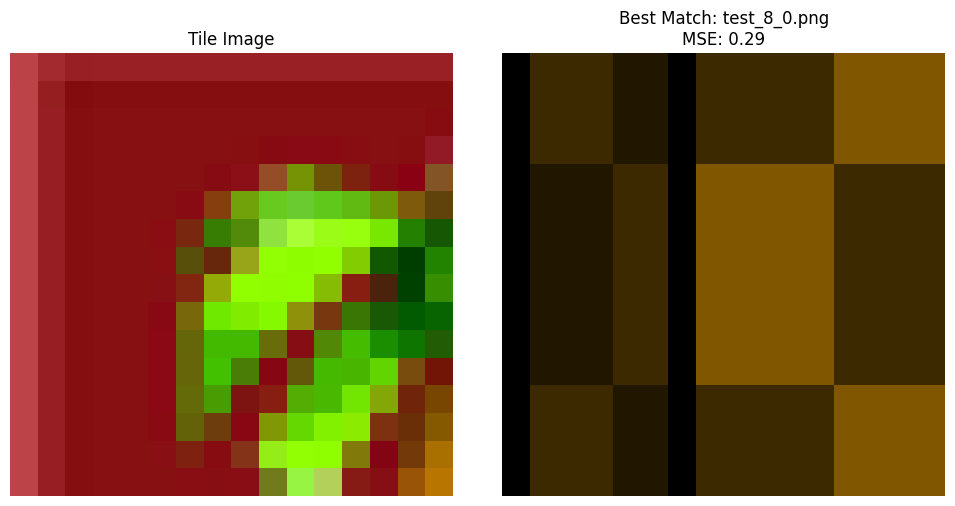

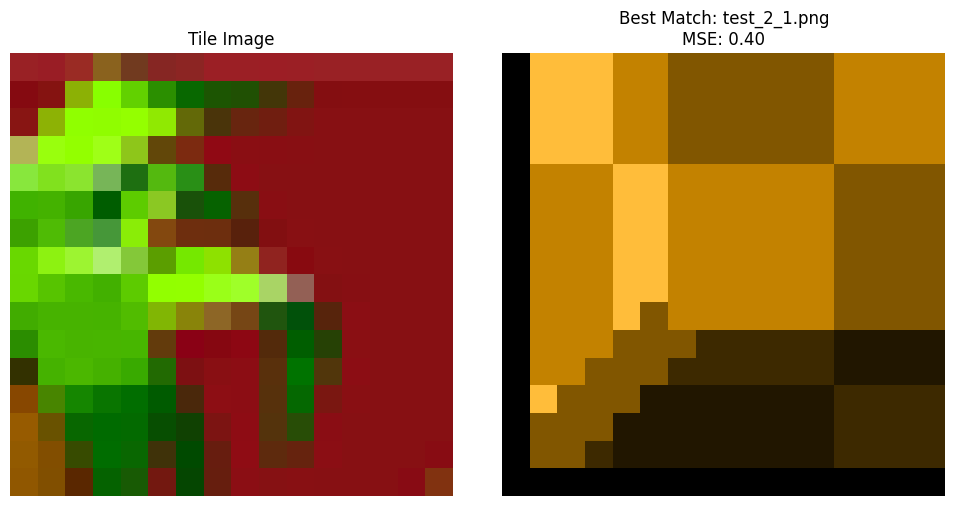

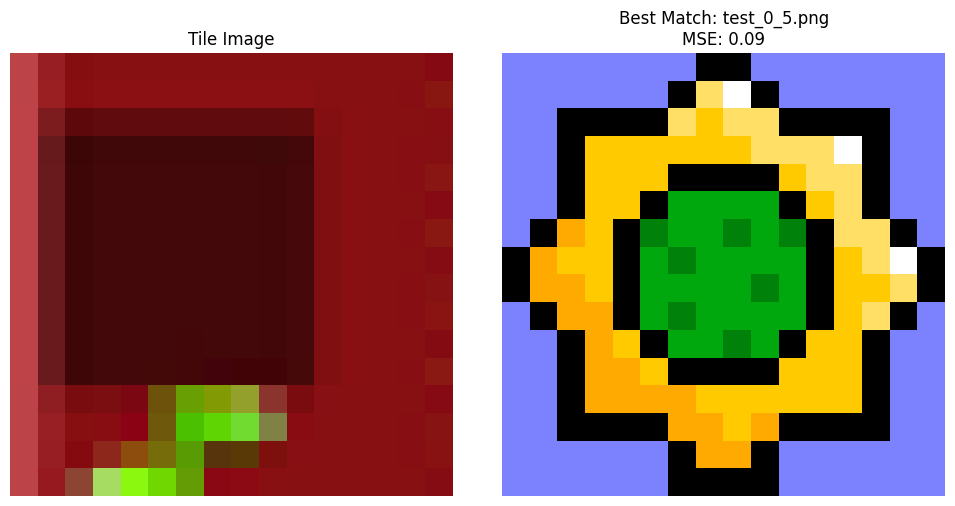

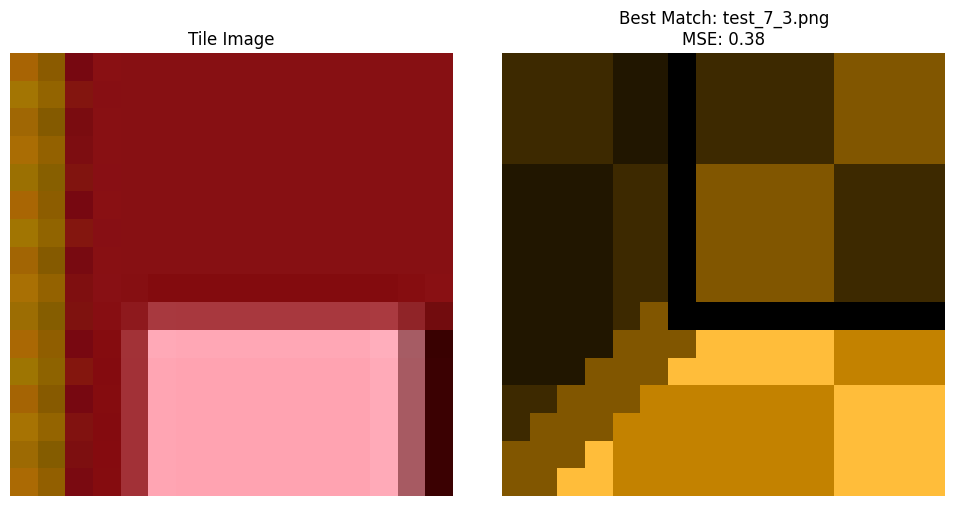

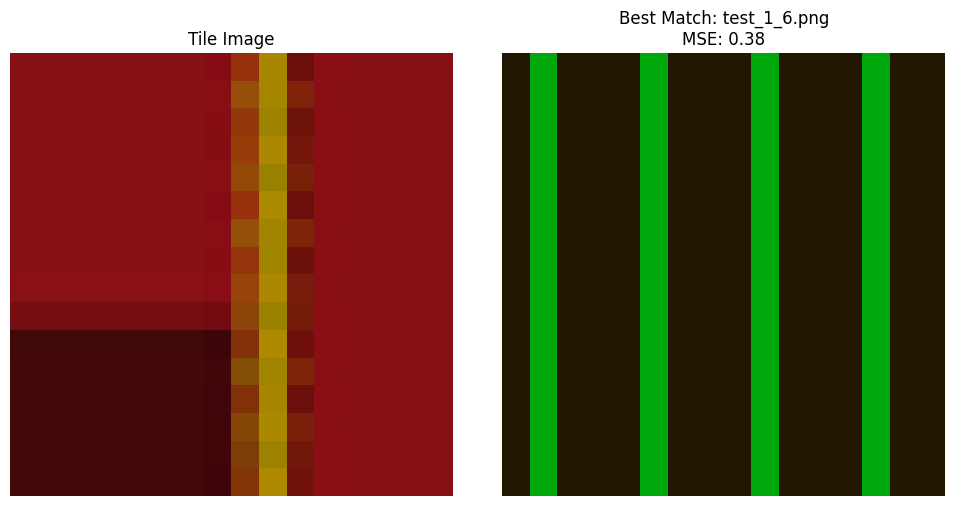

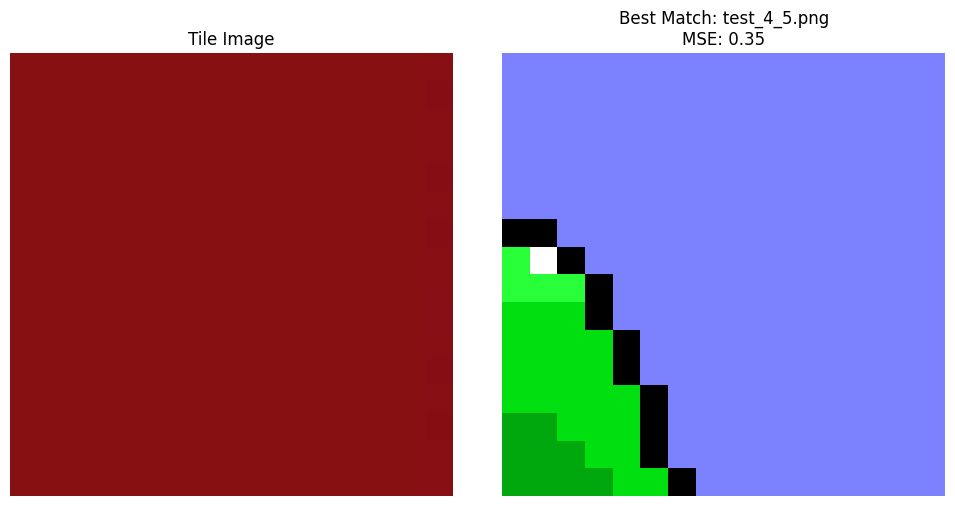

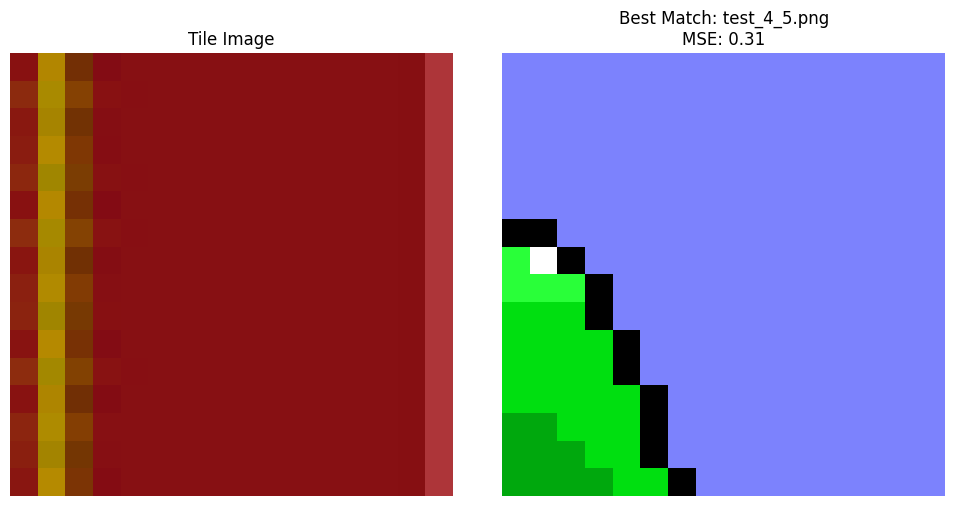

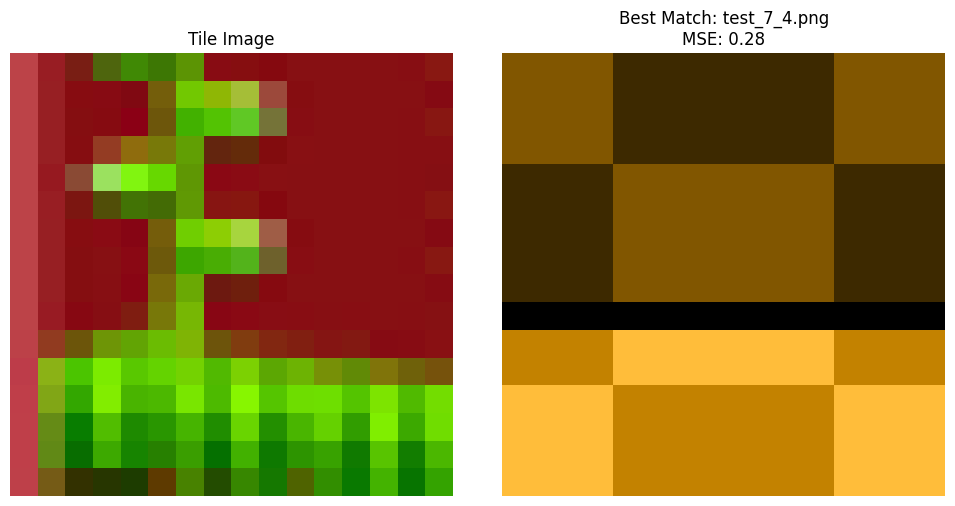

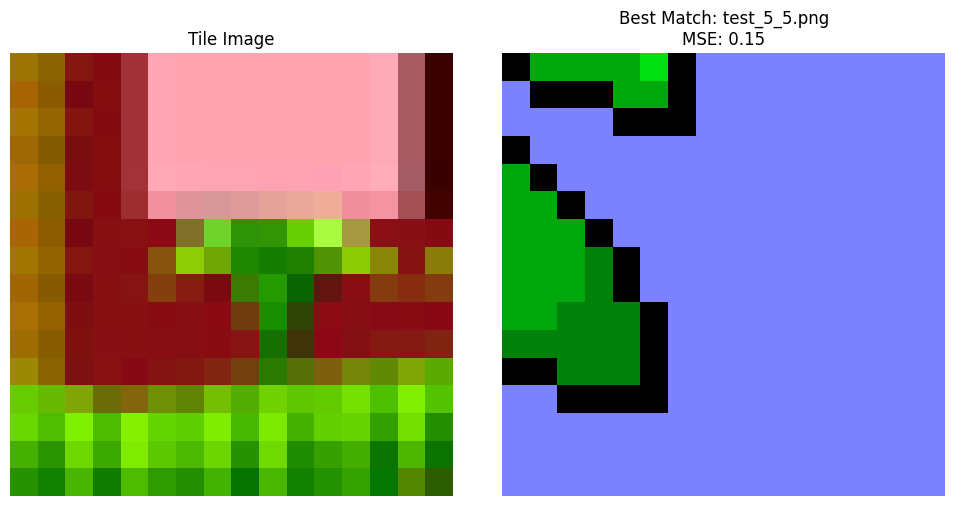

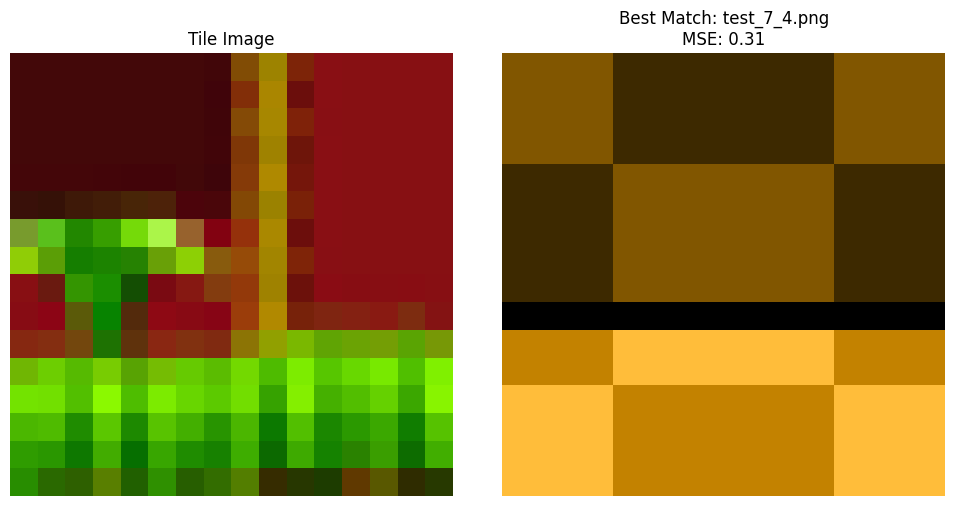

In [ ]:
# Matching process
tile_dir = "GreenHillZone_Tiles"
results = []
cpt = 0

for map_folder in os.listdir(tile_dir):
    map_path = os.path.join(tile_dir, map_folder)
    if not os.path.isdir(map_path):
        continue

    for tile_file in os.listdir(map_path):
        tile_path = os.path.join(map_path, tile_file)

        if not tile_file.endswith((".png", ".jpg", ".jpeg")):
            continue

        tile = Image.open(tile_path).convert("RGB")

        # Find the closest match using ssim
        ssim_scores = {
            sprite_name: compute_ssim(tile, sprite_img)
            for sprite_name, sprite_img in sprite_images.items()
        }

        best_match = max(ssim_scores, key=ssim_scores.get)
        best_score = ssim_scores[best_match]

        results.append(
            {
                "map_tile": f"{map_folder}/{tile_file}",
                "best_match_sprite": best_match,
                "ssim_score": best_score,
            }
        )

        # Display the comparison
        if cpt < 10:
            show_image_comparison(tile, best_match, best_score)
            cpt += 1

In [185]:
df_results = pd.DataFrame(results)

df_results.to_excel("ssim_tile_matching_results.xlsx", index=False)

The SSIM (Structural Similarity Index Measure) score is a metric used to assess the quality of images by comparing the structural similarity between two images. It’s particularly useful in image processing to evaluate how close the generated image is to the reference or original image. Here's how you interpret the SSIM score:

Range:

The SSIM score ranges from **-1 to 1**:

**1**: Perfect similarity between the two images. The images are identical.

**0**: No structural similarity between the two images.

**Negative values**: Indicates that the images are not only different but may have inverted features (this is very rare in typical cases).

Interpretation:

**Values close to 1:** Indicates high structural similarity, meaning the two images are very similar. The closer the score is to 1, the more similar the images are, especially in terms of luminance, contrast, and structure.

**Values around 0.5 to 0.7**: Suggests a moderate similarity. The images have some differences, but they are still relatively similar in structure.

**Values lower than 0.5**: Indicates poor structural similarity, suggesting that the images differ significantly in their structural features.

### c - Feature Matching using ORB (Oriented FAST and Rotated BRIEF)

def orb_similarity(image1, image2):
    orb = cv2.ORB_create(nfeatures=5000, scaleFactor=1.2, edgeThreshold=31)

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(np.array(image1), None)
    kp2, des2 = orb.detectAndCompute(np.array(image2), None)
    
    if des1 is None or des2 is None:
        return 0
    
    # Use BFMatcher with crossCheck=False (you can experiment with crossCheck=True)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Perform KNN match to apply ratio test for better quality matches
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.app
    
    # If no good matches found, return 0
    if len(good_matches) == 0:
        return 0

    # Normalize the number of good matches by the total keypoints
    match_score = len(good_matches) / float(min(len(kp1), len(kp2)))
    
    return match_score


tile_dir = "GreenHillZone_Tiles"
results = []
cpt = 0

for map_folder in os.listdir(tile_dir):
    map_path = os.path.join(tile_dir, map_folder)
    if not os.path.isdir(map_path):
        continue
    
    for tile_file in os.listdir(map_path):
        tile_path = os.path.join(map_path, tile_file)
        
        if not tile_file.endswith((".png", ".jpg", ".jpeg")):
            continue
        
        tile = Image.open(tile_path).convert("RGB")

        # Find the closest match using orb
        orb_scores = {sprite_name: orb_similarity(tile, sprite_img) for sprite_name, sprite_img in sprite_images.items()}
        
        best_match = max(orb_scores, key=orb_scores.get)
        best_score = orb_scores[best_match] 
        
        results.append({
            "map_tile": f"{map_folder}/{tile_file}",
            "best_match_sprite": best_match,         
            "orb_score": best_score               
        })
        
        # Display the comparison
        if cpt < 15:
            show_image_comparison(tile, best_match, best_score)
            cpt += 1

In [186]:
df_results = pd.DataFrame(results)

df_results.to_excel("orb_tile_matching_results.xlsx", index=False)

## 4 - CNN -  Convolutional Neural Network

In [10]:
def preprocess_image(image, target_size=(16, 16)):

    image = image.resize(target_size)  # Resize image to match the target size
    image = np.array(image)  # Convert to numpy array
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

In [11]:
# Prepare sprite images and labels
sprite_dir = "general_map_sprite"
sprite_images = {}
sprite_labels = []

In [12]:
for sprite_file in os.listdir(sprite_dir):
    sprite_path = os.path.join(sprite_dir, sprite_file)
    if sprite_file.endswith((".png", ".jpg", ".jpeg")):
        sprite = Image.open(sprite_path).convert("RGB")
        sprite_images[sprite_file] = preprocess_image(
            sprite
        )  # Preprocess sprite images
        sprite_labels.append(
            sprite_file.split(".")[0]
        )  # Get sprite name without file extension

In [190]:
# Encode sprite labels to integers for classification
label_encoder = LabelEncoder()
sprite_labels_encoded = label_encoder.fit_transform(sprite_labels)
sprite_labels_one_hot = to_categorical(sprite_labels_encoded)

In [191]:
# Prepare tile images to be classified
tile_dir = "GreenHillZone_Tiles"
tile_images = []

for map_folder in os.listdir(tile_dir):
    map_path = os.path.join(tile_dir, map_folder)
    if not os.path.isdir(map_path):
        continue

    for tile_file in os.listdir(map_path):
        tile_path = os.path.join(map_path, tile_file)

        if tile_file.endswith((".png", ".jpg", ".jpeg")):
            tile = Image.open(tile_path).convert("RGB")
            tile_images.append(preprocess_image(tile))  # Preprocess each tile image

In [192]:
def create_cnn_model(input_shape=(16, 16, 3), num_classes=len(sprite_labels_encoded)):
    model = Sequential()
    model.add(
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape)
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )  # Kept the third pooling, but size won't shrink to 0

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))  # Prevent overfitting
    model.add(
        Dense(num_classes, activation="softmax")
    )  # Output layer for classification

    model.compile(
        optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [193]:
# Train the CNN model (this assumes you have a prepared sprite dataset for training)
model = create_cnn_model(
    input_shape=(16, 16, 3), num_classes=len(label_encoder.classes_)
)
model.summary()

C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 60)             │        30,780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,684 (1.48 MB)

 Trainable params: 386,684 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [194]:
class SpriteDataGenerator(Sequence):
    def __init__(
        self,
        sprite_images_dict,
        sprite_labels,
        label_encoder,
        batch_size=32,
        input_size=(16, 16, 3),
        shuffle=True,
    ):
        """
        Custom data generator for training CNN models on sprite images.

        :param sprite_images_dict: Dictionary {filename: image_array}
        :param sprite_labels: List of labels corresponding to filenames
        :param label_encoder: Fitted LabelEncoder for label transformation
        :param batch_size: Number of samples per batch
        :param input_size: Expected image input size (default: (16, 16, 3))
        :param shuffle: Whether to shuffle data at the end of each epoch
        """
        self.sprite_images_dict = sprite_images_dict
        self.sprite_labels = sprite_labels
        self.label_encoder = label_encoder
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.image_keys = list(sprite_images_dict.keys())  # Extract filenames
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch"""
        return int(np.floor(len(self.image_keys) / self.batch_size))

    def __getitem__(self, index):
        """Returns a batch of data at the given index"""
        batch_keys = self.image_keys[
            index * self.batch_size : (index + 1) * self.batch_size
        ]
        return self.__data_generation(batch_keys)

    def on_epoch_end(self):
        """Shuffles the dataset at the end of each epoch"""
        if self.shuffle:
            np.random.shuffle(self.image_keys)

    def __data_generation(self, batch_keys):
        """Generates data for the batch"""
        batch_images = []
        batch_labels = []

        for key in batch_keys:
            image = self.sprite_images_dict[key]  # Get image array
            label = key.split(".")[0]  # Extract label from filename
            encoded_label = self.label_encoder.transform([label])[0]  # Encode label
            one_hot_label = tf.keras.utils.to_categorical(
                encoded_label, num_classes=len(self.label_encoder.classes_)
            )

            batch_images.append(image)
            batch_labels.append(one_hot_label)

        return np.array(batch_images), np.array(batch_labels)

In [195]:
# Create the data generator
sprite_keys = list(sprite_images.keys())

# train_keys, val_keys = train_test_split(sprite_keys, test_size=0.2, random_state=42)

In [196]:
# Create separate generators
train_generator = SpriteDataGenerator(
    {k: sprite_images[k] for k in sprite_keys},
    [k.split(".")[0] for k in sprite_keys],
    label_encoder,
    batch_size=16,
)

val_generator = SpriteDataGenerator({k: sprite_images[k] for k in val_keys}, 
                                    [k.split('.')[0] for k in val_keys], 
                                    label_encoder, batch_size=2)

In [197]:
print(f"Train generator size: {len(train_generator)}")
# print(f"Validation generator size: {len(val_generator)}")
print(f"Train batch size: {train_generator.batch_size}")

Train generator size: 3
Train batch size: 16


In [198]:
early_stopping = EarlyStopping(
    monitor="loss",
    patience=10,
    min_delta=0.001,  # Stops only if improvement is less than 0.001
    restore_best_weights=True,
)

history = model.fit(train_generator,  
                    epochs=1000,  # Set a high number, but early stopping will stop it early
                    callbacks=[early_stopping],  
                    verbose=1)

In [199]:
# If you already have a pre-trained model, you can skip training and load the model:
model = load_model("sprite_cnn_model.h5")  # Load the pre-trained model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │        30,780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,686 (1.48 MB)

 Trainable params: 386,684 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


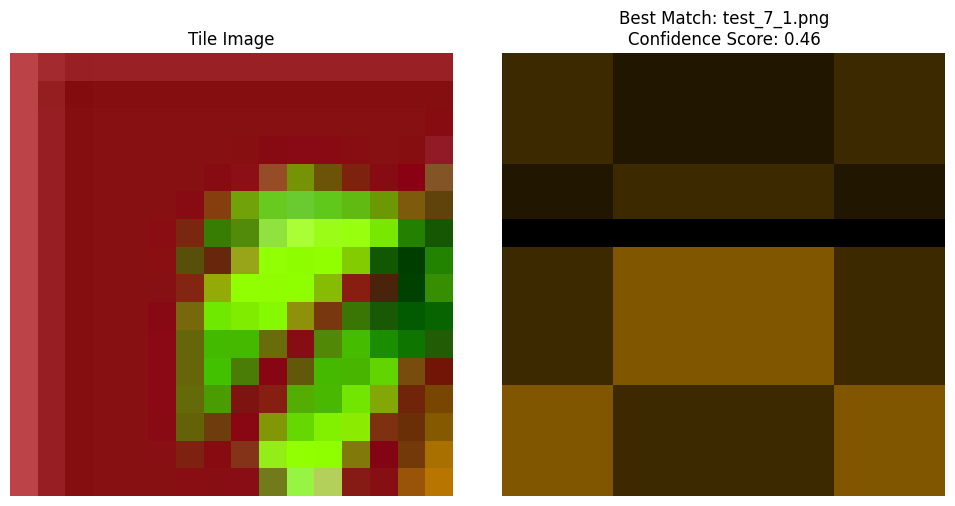

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


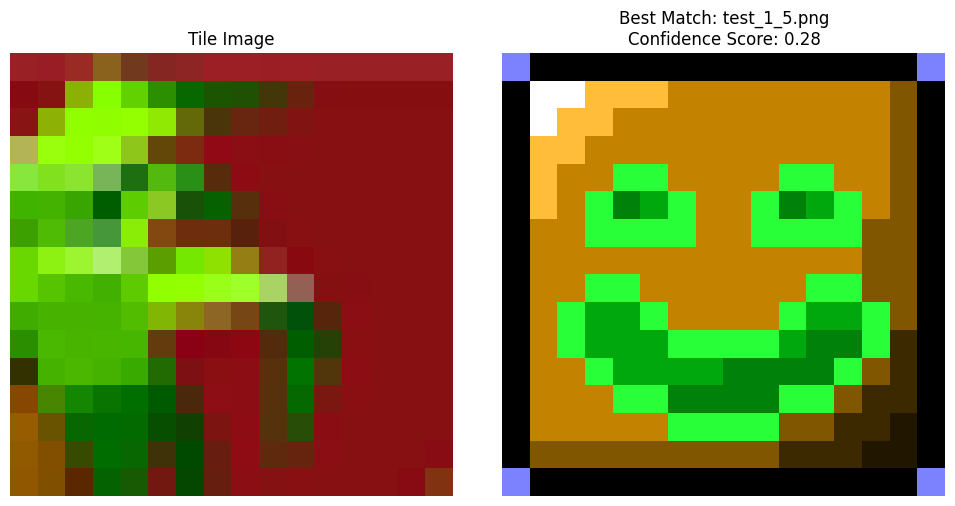

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


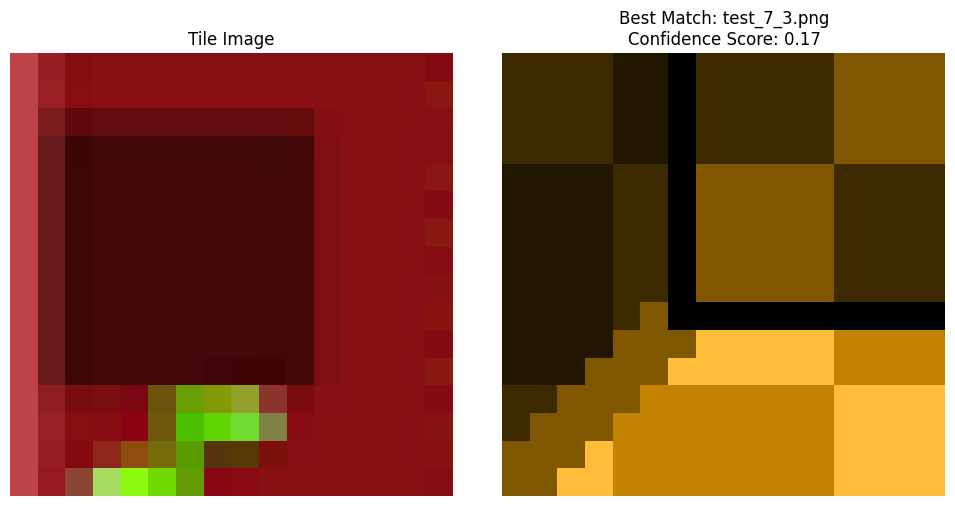

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


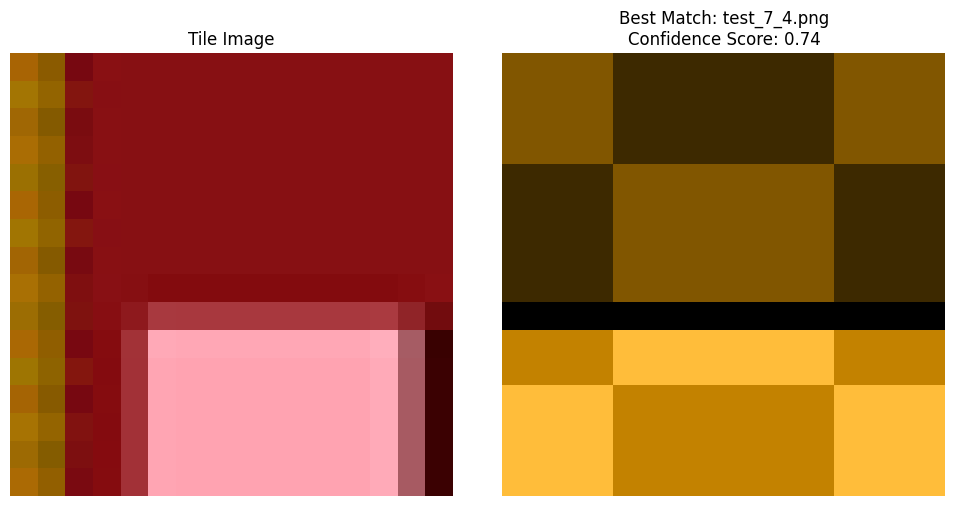

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


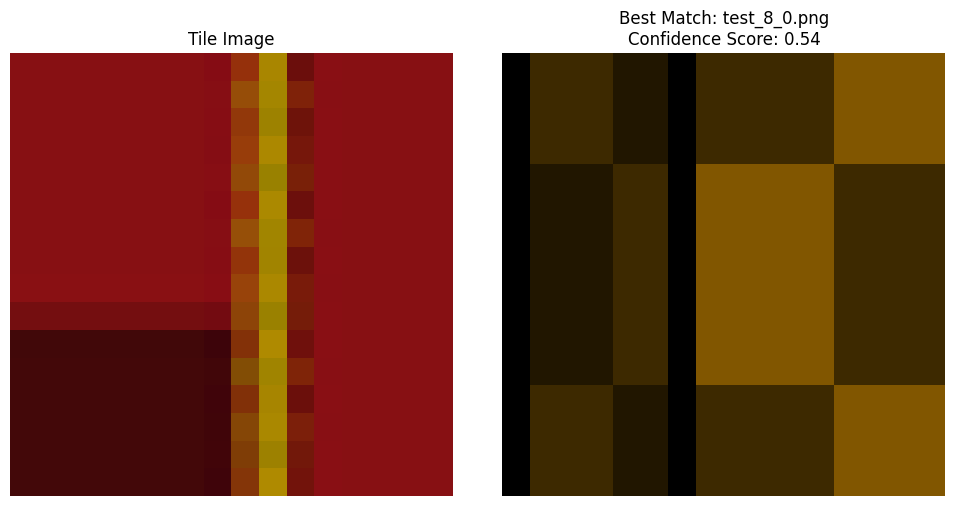

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


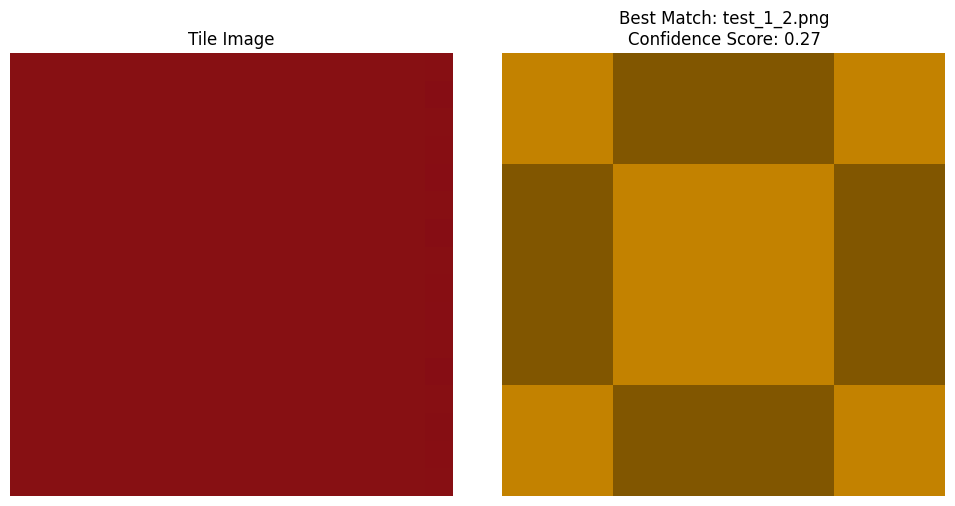

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


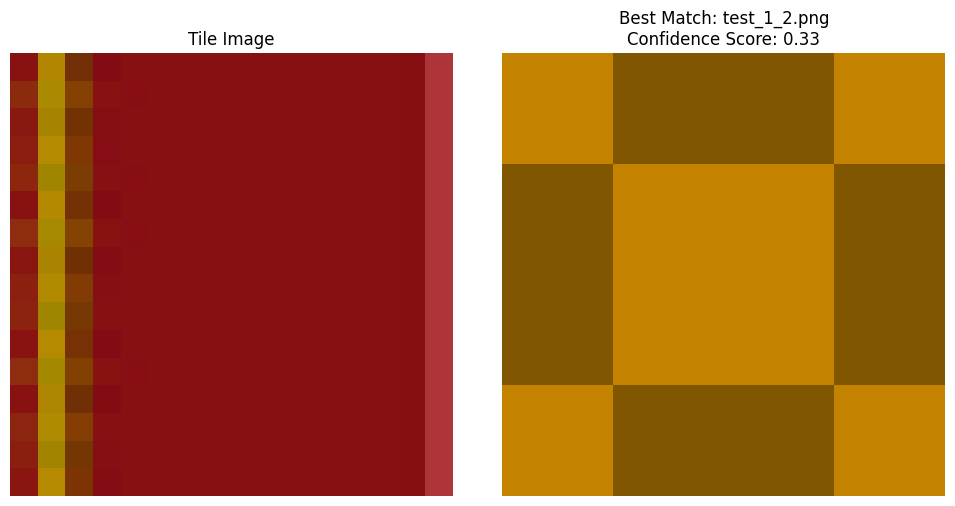

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


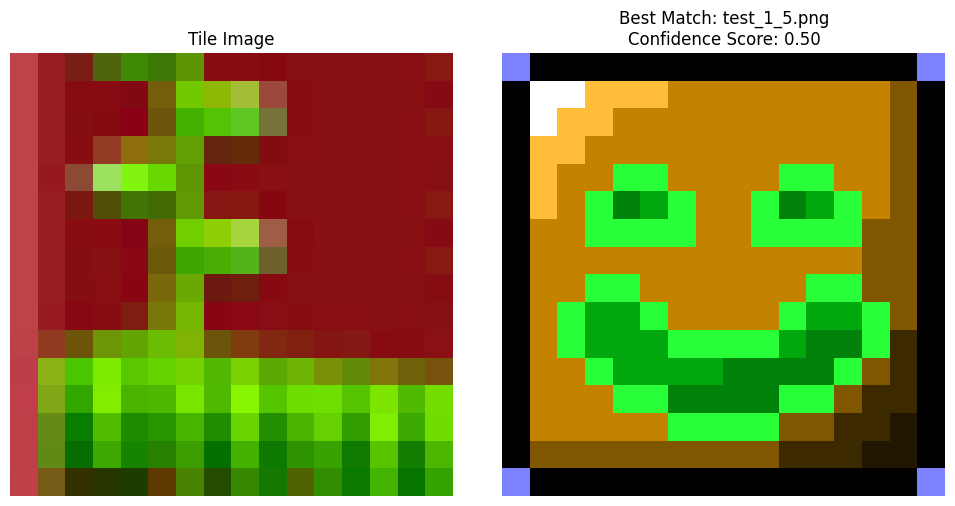

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


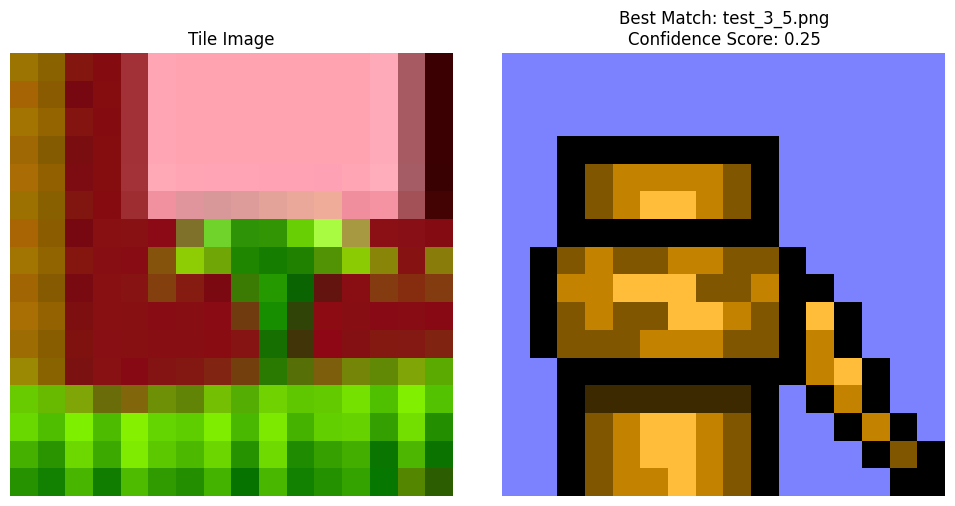

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


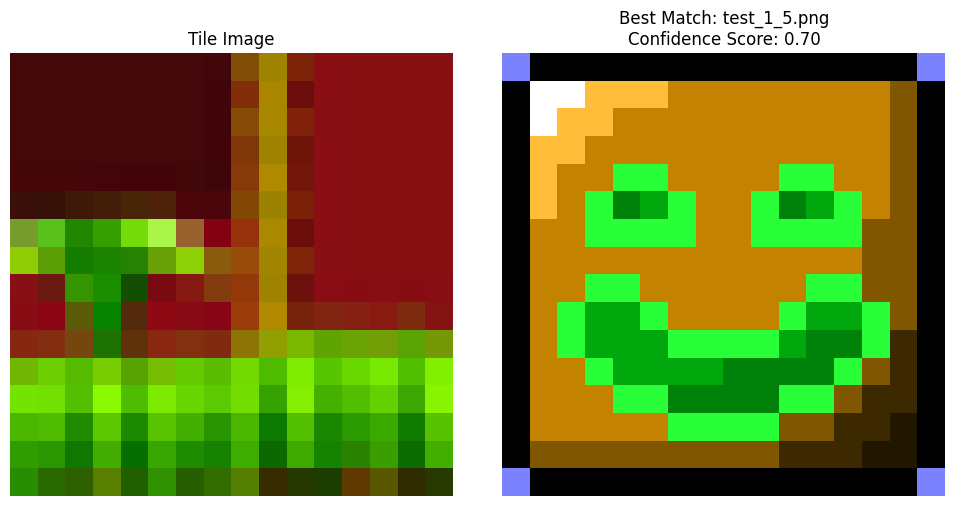

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [200]:
# Perform tile classification and store results
results = []
cpt = 0

for map_folder in os.listdir(tile_dir):
    map_path = os.path.join(tile_dir, map_folder)
    if not os.path.isdir(map_path):
        continue

    for tile_file in os.listdir(map_path):
        tile_path = os.path.join(map_path, tile_file)

        if not tile_file.endswith((".png", ".jpg", ".jpeg")):
            continue

        tile = Image.open(tile_path).convert("RGB")
        tile_preprocessed = preprocess_image(tile)  # Preprocess the tile

        # Predict the tile's class using the CNN model
        tile_input = np.expand_dims(tile_preprocessed, axis=0)  # Add batch dimension
        predictions = model.predict(tile_input)
        predicted_class_idx = np.argmax(
            predictions
        )  # Get the index of the most likely class
        predicted_class = label_encoder.classes_[
            predicted_class_idx
        ]  # Get the sprite name

        # Store the result
        results.append(
            {
                "map_tile": f"{map_folder}/{tile_file}",
                "best_match_sprite": predicted_class,
                "confidence_score": predictions[0][
                    predicted_class_idx
                ],  # Confidence score
            }
        )

        # Display the comparison (Optional, comment out if not needed)
        if cpt < 10:
            show_image_comparison(
                tile,
                f"{predicted_class}.png",
                predictions[0][predicted_class_idx],
                message="Confidence Score",
            )
            cpt += 1

### Save the trained model
model.save('sprite_cnn_model.h5')

In [ ]:
# Save the results to an Excel file
df_results = pd.DataFrame(results)
df_results.to_excel("cnn_matching_results.xlsx", index=False)

## 5 - Grey filter attempt 

### If you already have a pre-trained model, you can skip training and load the model:
grey_model = load_model('grey_sprite_cnn_model.h5')  # Load the pre-trained model
grey_model.summary()

In [ ]:
grey_sprite_dir = "general_map_sprite"
grey_sprite_images = {}

for sprite_file in os.listdir(grey_sprite_dir):
    sprite_path = os.path.join(grey_sprite_dir, sprite_file)
    if sprite_file.endswith((".png", ".jpg", ".jpeg")):
        sprite = Image.open(sprite_path).convert("L")  # Ensure consistent color mode
        grey_sprite_images[sprite_file] = sprite

In [ ]:
def grey_preprocess_image(image, target_size=(16, 16)):
    image = image.resize(target_size)  # Resize to target size
    image = np.array(
        image, dtype=np.float32
    )  # Convert to numpy array (float32 for stability)
    image = image / 255.0  # Normalize pixel values to [0, 1]

    if len(image.shape) == 2:  # Ensure grayscale image has a channel dimension
        image = np.expand_dims(image, axis=-1)  # (16, 16) -> (16, 16, 1)

    return image

In [ ]:
grey_sprite_images["test_0_0.png"]

In [ ]:
grey_sprite_keys = list(grey_sprite_images.keys())
grey_sprite_labels = [
    grey_sprite_keys[i].split(".")[0] for i in range(len(grey_sprite_keys))
]

In [ ]:
# Encode sprite labels to integers for classification
grey_label_encoder = LabelEncoder()
grey_sprite_labels_encoded = grey_label_encoder.fit_transform(grey_sprite_labels)
grey_sprite_labels_one_hot = to_categorical(grey_sprite_labels_encoded)

In [ ]:
grey_model = create_cnn_model(
    input_shape=(16, 16, 1), num_classes=len(grey_label_encoder.classes_)
)
grey_model.summary()

C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │        30,780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,108 (1.47 MB)

 Trainable params: 386,108 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class GreySpriteDataGenerator(Sequence):
    def __init__(
        self,
        sprite_images_dict,
        sprite_labels,
        label_encoder,
        batch_size=32,
        input_size=(16, 16, 3),
        shuffle=True,
    ):
        """
        Custom data generator for training CNN models on sprite images.

        :param sprite_images_dict: Dictionary {filename: image_array}
        :param sprite_labels: List of labels corresponding to filenames
        :param label_encoder: Fitted LabelEncoder for label transformation
        :param batch_size: Number of samples per batch
        :param input_size: Expected image input size (default: (16, 16, 3))
        :param shuffle: Whether to shuffle data at the end of each epoch
        """
        self.sprite_images_dict = sprite_images_dict
        self.sprite_labels = sprite_labels
        self.label_encoder = label_encoder
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.image_keys = list(sprite_images_dict.keys())  # Extract filenames
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch"""
        return int(np.floor(len(self.image_keys) / self.batch_size))

    def __getitem__(self, index):
        """Returns a batch of data at the given index"""
        batch_keys = self.image_keys[
            index * self.batch_size : (index + 1) * self.batch_size
        ]
        return self.__data_generation(batch_keys)

    def on_epoch_end(self):
        """Shuffles the dataset at the end of each epoch"""
        if self.shuffle:
            np.random.shuffle(self.image_keys)

    def __data_generation(self, batch_keys):
        """Generates data for the batch"""
        batch_images = []
        batch_labels = []

        for key in batch_keys:
            image = self.sprite_images_dict[key]  # Get image array
            label = key.split(".")[0]  # Extract label from filename
            encoded_label = self.label_encoder.transform([label])[0]  # Encode label
            one_hot_label = tf.keras.utils.to_categorical(
                encoded_label, num_classes=len(self.label_encoder.classes_)
            )

            batch_images.append(image)
            batch_labels.append(one_hot_label)

        return np.array(batch_images), np.array(batch_labels)

In [ ]:
# Create separate generators
grey_train_generator = GreySpriteDataGenerator(
    {k: grey_sprite_images[k] for k in grey_sprite_keys},
    [k.split(".")[0] for k in grey_sprite_keys],
    grey_label_encoder,
    batch_size=16,
)

In [ ]:
def grey_show_image_comparison(tile, best_sprite, mse_score, message="MSE"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Convert images to grayscale
    tile = tile.convert("L")
    best_sprite_img = Image.open(os.path.join(sprite_dir, best_sprite)).convert("L")

    # Ensure grayscale display
    axes[0].imshow(tile, cmap="gray")  # ✅ Force grayscale colormap
    axes[0].set_title("Tile Image")
    axes[0].axis("off")

    axes[1].imshow(best_sprite_img, cmap="gray")  # ✅ Force grayscale colormap
    axes[1].set_title(f"Best Match: {best_sprite}\n{message}: {mse_score:.2f}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
grey_early_stopping = EarlyStopping(
    monitor="loss",
    patience=10,
    min_delta=0.001,  # Stops only if improvement is less than 0.001
    restore_best_weights=True,
)

In [ ]:
grey_history = grey_model.fit(
    grey_train_generator,
    epochs=1000,  # Set a high number, but early stopping will stop it early
    callbacks=[grey_early_stopping],
    verbose=1,
)

Epoch 1/1000


C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0000e+00 - loss: 30.5850 
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 13.8359 
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 7.9301 
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0990 - loss: 5.0345 
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0469 - loss: 4.4238     
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0573 - loss: 3.8869     
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0104 - loss: 3.9281    
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1042 - loss: 3.5948 
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2109 - loss: 3.3033 
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3203 - loss: 3.1767
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2240 - loss: 3.1703
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


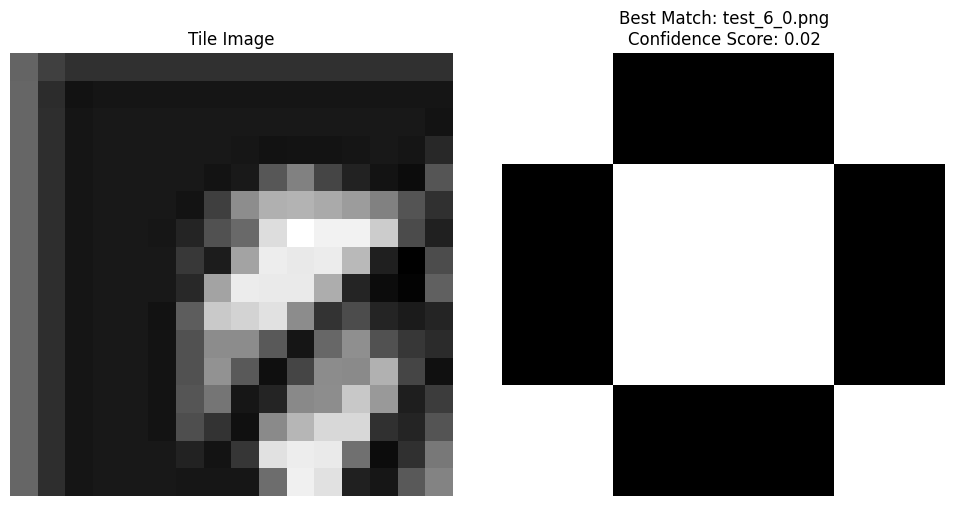

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


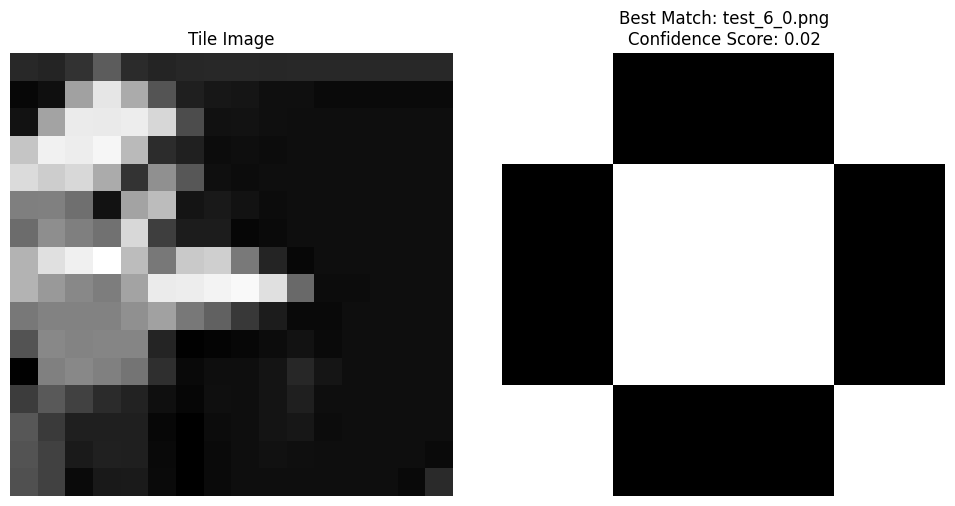

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


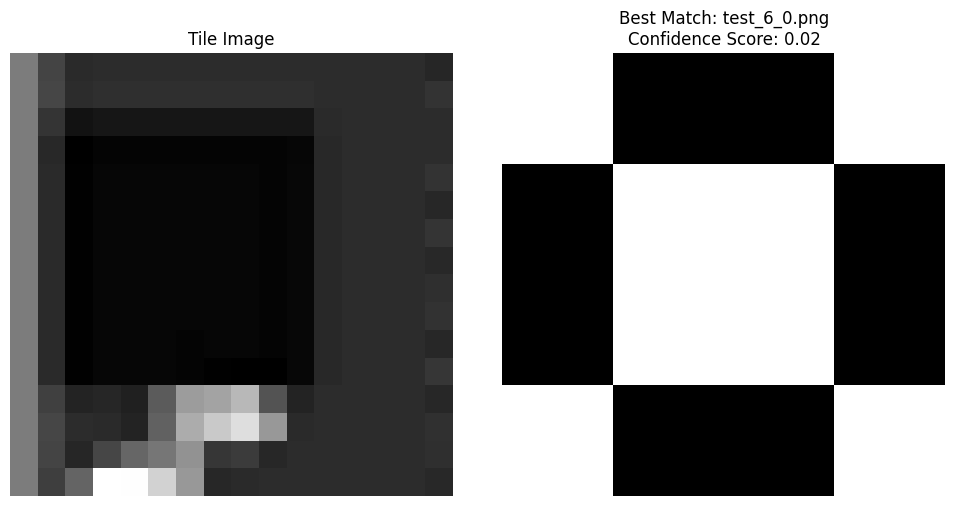

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


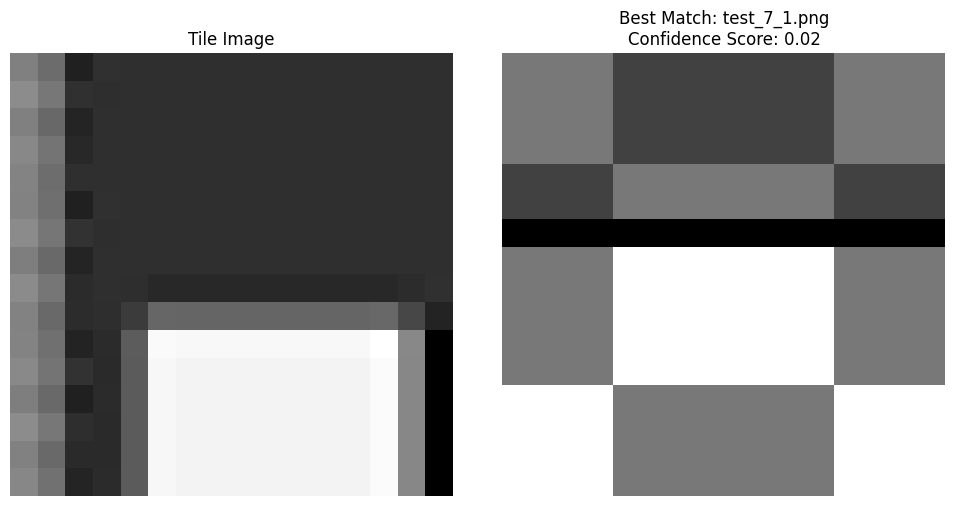

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


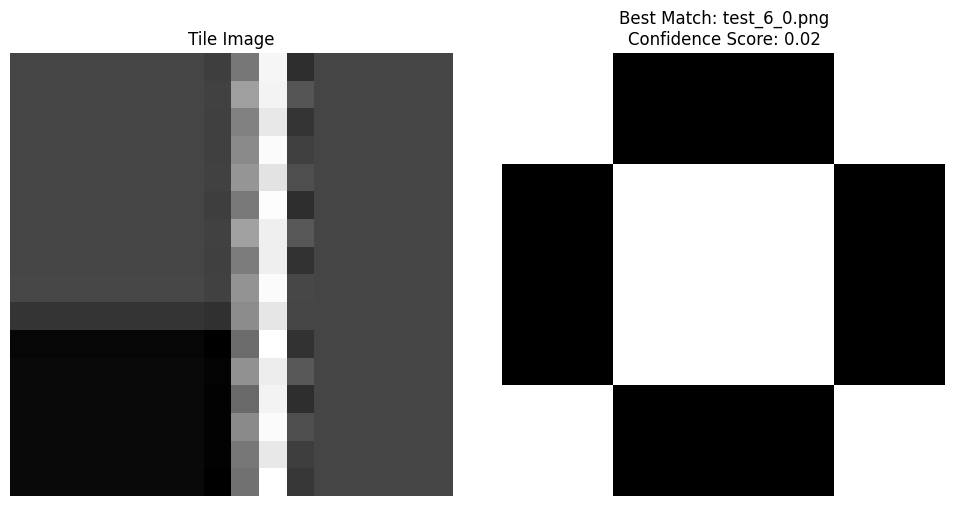

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


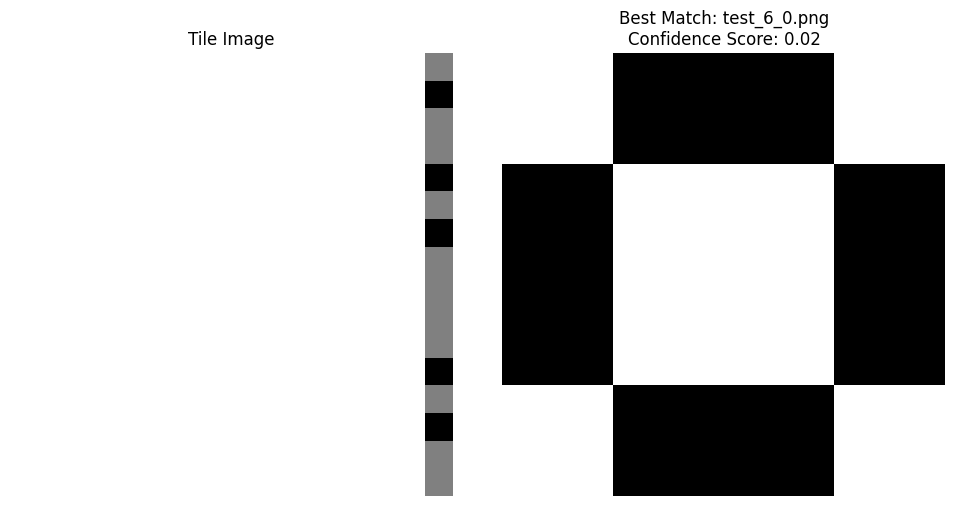

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


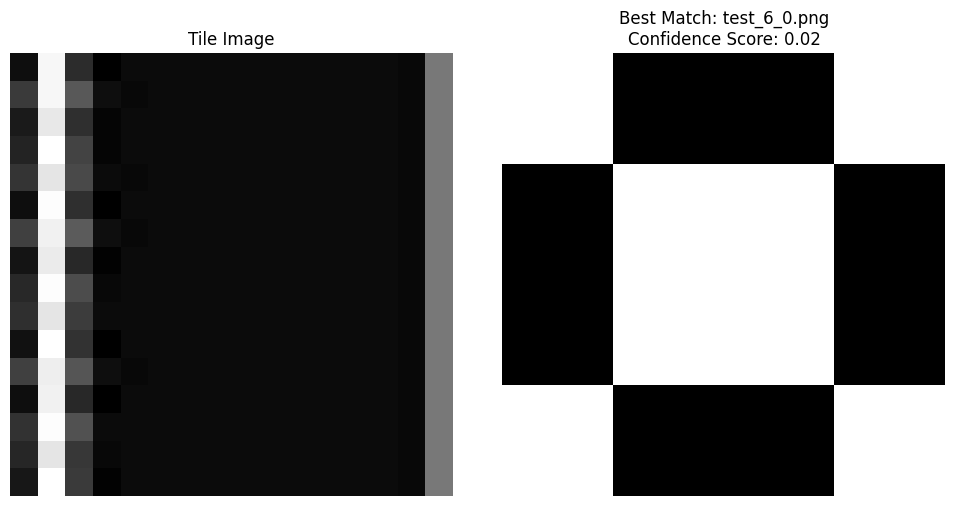

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


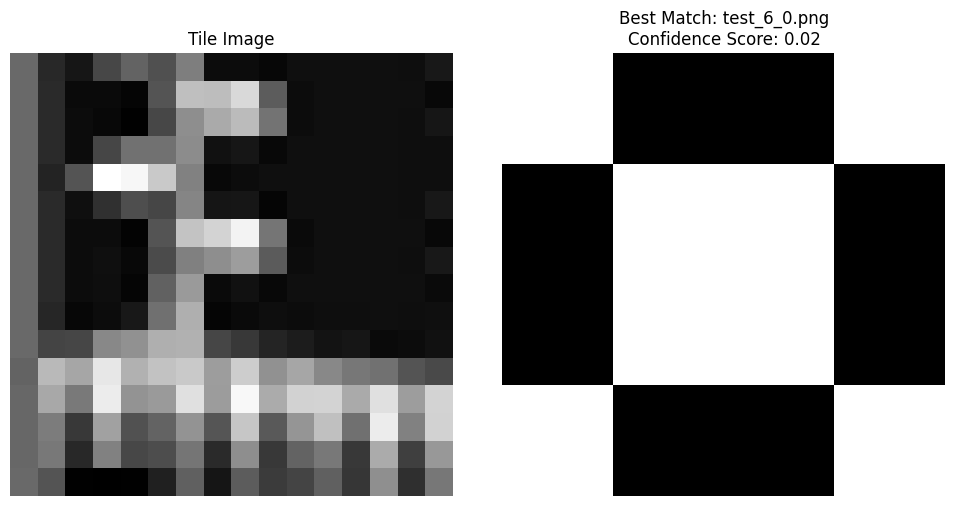

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


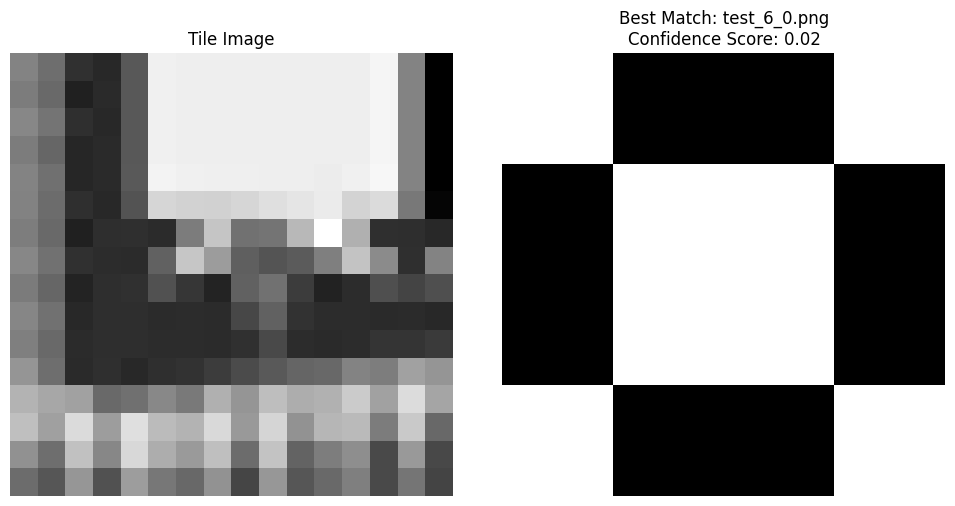

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


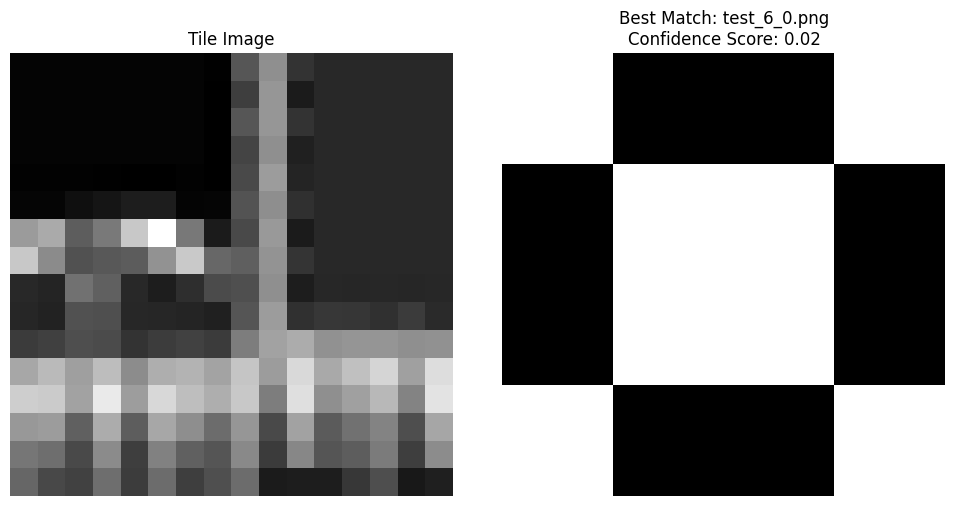

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

In [ ]:
# Perform tile classification and store results
results = []
cpt = 0

for map_folder in os.listdir(tile_dir):
    map_path = os.path.join(tile_dir, map_folder)
    if not os.path.isdir(map_path):
        continue

    for tile_file in os.listdir(map_path):
        tile_path = os.path.join(map_path, tile_file)

        if not tile_file.endswith((".png", ".jpg", ".jpeg")):
            continue

        tile = Image.open(tile_path).convert("L")
        tile_preprocessed = grey_preprocess_image(tile)  # Preprocess the tile

        # Predict the tile's class using the CNN model
        tile_input = np.expand_dims(tile_preprocessed, axis=0)  # Add batch dimension
        predictions = grey_model.predict(tile_input)
        predicted_class_idx = np.argmax(
            predictions
        )  # Get the index of the most likely class
        predicted_class = grey_label_encoder.classes_[
            predicted_class_idx
        ]  # Get the sprite name

        # Store the result
        results.append(
            {
                "map_tile": f"{map_folder}/{tile_file}",
                "best_match_sprite": predicted_class,
                "confidence_score": predictions[0][
                    predicted_class_idx
                ],  # Confidence score
            }
        )

        # Display the comparison (Optional, comment out if not needed)
        if cpt < 10:
            grey_show_image_comparison(
                tile,
                f"{predicted_class}.png",
                predictions[0][predicted_class_idx],
                message="Confidence Score",
            )
            cpt += 1

In [ ]:
# Save the trained model
grey_model.save("grey_sprite_cnn_model.h5")

In [ ]:
# Save the results to an Excel file
df_results = pd.DataFrame(results)
df_results.to_excel("grey_cnn_matching_results.xlsx", index=False)

## 6 - Pretrained models

In [ ]:
model = TFViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_classes = len(label_encoder.classes_)

### Replace the classifier layer
model.classifier = tf.keras.layers.Dense(num_classes)

## 7 - Matching with closer sprite 

Use this method to look for the better way a improement in the classification would definitely mean that there's a problem in the way or sprites are used and therefore it would mean that we have to find better even if we actually know that we have used the "best" fot the project of semester 1 aims.

### First method : Brut split with PIL

In [ ]:
output_folder = "GreenHillZone_Tiles_test"
input_image_path = "Sonic1_MD_Map_Ghz1.png"

In [ ]:
# Create output directory if not exists
os.makedirs(output_folder, exist_ok=True)

In [ ]:
image = Image.open(input_image_path)
image_width, image_height = image.size

In [ ]:
# Tile sizes
tile_size = 80
subtile_size = 16

map_index = 1

# Loop through the image, extracting 80x80 tiles
for y in range(0, image_height, tile_size):
    for x in range(0, image_width, tile_size):
        # Crop the 80x80 tile
        tile = image.crop((x, y, x + tile_size, y + tile_size))

        # Create "map_X" folder
        map_folder = os.path.join(output_folder, f"map_{map_index}")
        os.makedirs(map_folder, exist_ok=True)

        # Save the 80x80 tile
        # tile_path = os.path.join(map_folder, f"tile_{map_index}.png")
        # tile.save(tile_path)

        # Split the 80x80 tile into 16x16 sub-tiles
        subtile_index = 1
        for sy in range(0, tile_size, subtile_size):
            for sx in range(0, tile_size, subtile_size):
                subtile = tile.crop((sx, sy, sx + subtile_size, sy + subtile_size))

                # Save sub-tiles
                subtile_path = os.path.join(map_folder, f"subtile_{subtile_index}.png")
                subtile.save(subtile_path)

                subtile_index += 1  # Increment subtile index

        map_index += 1  # Increment map index for next tile

#### Rematch using CNN (best result)

In [ ]:
def show_image_comparison(tile, best_sprite, mse_score, message="MSE"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(tile)
    axes[0].set_title("Tile Image")
    axes[0].axis("off")

    # Load the best matching sprite for display
    best_sprite_img = Image.open(os.path.join(sprite_dir, best_sprite)).convert("RGB")
    axes[1].imshow(best_sprite_img)
    axes[1].set_title(f"Best Match: {best_sprite}\n{message}: {mse_score:.2f}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def preprocess_image(image, target_size=(16, 16)):

    image = image.resize(target_size)  # Resize image to match the target size
    image = np.array(image)  # Convert to numpy array
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

In [ ]:
# Prepare sprite images and labels
sprite_dir = "general_map_sprite"
sprite_images = {}
sprite_labels = []

In [ ]:
for sprite_file in os.listdir(sprite_dir):
    sprite_path = os.path.join(sprite_dir, sprite_file)
    if sprite_file.endswith((".png", ".jpg", ".jpeg")):
        sprite = Image.open(sprite_path).convert("RGB")
        sprite_images[sprite_file] = preprocess_image(
            sprite
        )  # Preprocess sprite images
        sprite_labels.append(
            sprite_file.split(".")[0]
        )  # Get sprite name without file extension

In [ ]:
# Encode sprite labels to integers for classification
label_encoder = LabelEncoder()
sprite_labels_encoded = label_encoder.fit_transform(sprite_labels)
sprite_labels_one_hot = to_categorical(sprite_labels_encoded)

In [ ]:
# Prepare tile images to be classified
tile_dir = "GreenHillZone_Tiles_test"
tile_images = []

for map_folder in os.listdir(tile_dir):
    map_path = os.path.join(tile_dir, map_folder)
    if not os.path.isdir(map_path):
        continue

    for tile_file in os.listdir(map_path):
        tile_path = os.path.join(map_path, tile_file)

        if tile_file.endswith((".png", ".jpg", ".jpeg")):
            tile = Image.open(tile_path).convert("RGB")
            tile_images.append(preprocess_image(tile))  # Preprocess each tile image

In [ ]:
def create_cnn_model(input_shape=(16, 16, 3), num_classes=len(sprite_labels_encoded)):
    model = Sequential()
    model.add(
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape)
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )  # Kept the third pooling, but size won't shrink to 0

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))  # Prevent overfitting
    model.add(
        Dense(num_classes, activation="softmax")
    )  # Output layer for classification

    model.compile(
        optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [ ]:
# Train the CNN model (this assumes you have a prepared sprite dataset for training)
model = create_cnn_model(
    input_shape=(16, 16, 3), num_classes=len(label_encoder.classes_)
)
model.summary()

C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 60)             │        30,780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,684 (1.48 MB)

 Trainable params: 386,684 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class SpriteDataGenerator(Sequence):
    def __init__(
        self,
        sprite_images_dict,
        sprite_labels,
        label_encoder,
        batch_size=32,
        input_size=(16, 16, 3),
        shuffle=True,
    ):
        """
        Custom data generator for training CNN models on sprite images.

        :param sprite_images_dict: Dictionary {filename: image_array}
        :param sprite_labels: List of labels corresponding to filenames
        :param label_encoder: Fitted LabelEncoder for label transformation
        :param batch_size: Number of samples per batch
        :param input_size: Expected image input size (default: (16, 16, 3))
        :param shuffle: Whether to shuffle data at the end of each epoch
        """
        self.sprite_images_dict = sprite_images_dict
        self.sprite_labels = sprite_labels
        self.label_encoder = label_encoder
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.image_keys = list(sprite_images_dict.keys())  # Extract filenames
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch"""
        return int(np.floor(len(self.image_keys) / self.batch_size))

    def __getitem__(self, index):
        """Returns a batch of data at the given index"""
        batch_keys = self.image_keys[
            index * self.batch_size : (index + 1) * self.batch_size
        ]
        return self.__data_generation(batch_keys)

    def on_epoch_end(self):
        """Shuffles the dataset at the end of each epoch"""
        if self.shuffle:
            np.random.shuffle(self.image_keys)

    def __data_generation(self, batch_keys):
        """Generates data for the batch"""
        batch_images = []
        batch_labels = []

        for key in batch_keys:
            image = self.sprite_images_dict[key]  # Get image array
            label = key.split(".")[0]  # Extract label from filename
            encoded_label = self.label_encoder.transform([label])[0]  # Encode label
            one_hot_label = tf.keras.utils.to_categorical(
                encoded_label, num_classes=len(self.label_encoder.classes_)
            )

            batch_images.append(image)
            batch_labels.append(one_hot_label)

        return np.array(batch_images), np.array(batch_labels)

In [ ]:
# Create the data generator
sprite_keys = list(sprite_images.keys())

# train_keys, val_keys = train_test_split(sprite_keys, test_size=0.2, random_state=42)

In [ ]:
# Create separate generators
train_generator = SpriteDataGenerator(
    {k: sprite_images[k] for k in sprite_keys},
    [k.split(".")[0] for k in sprite_keys],
    label_encoder,
    batch_size=16,
)

In [ ]:
early_stopping = EarlyStopping(
    monitor="loss",
    patience=10,
    min_delta=0.001,  # Stops only if improvement is less than 0.001
    restore_best_weights=True,
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=1000,  # Set a high number, but early stopping will stop it early
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/1000


C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 4.1165
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0339 - loss: 4.0994
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0807 - loss: 4.0290
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0911 - loss: 4.0279
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0703 - loss: 4.0171
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0443 - loss: 3.9429 
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1406 - loss: 3.7725 
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1354 - loss: 3.6955
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0443 - loss: 3.7139
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1667 - loss: 3.3923
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0443 - loss: 3.5652 
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1146 - loss: 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


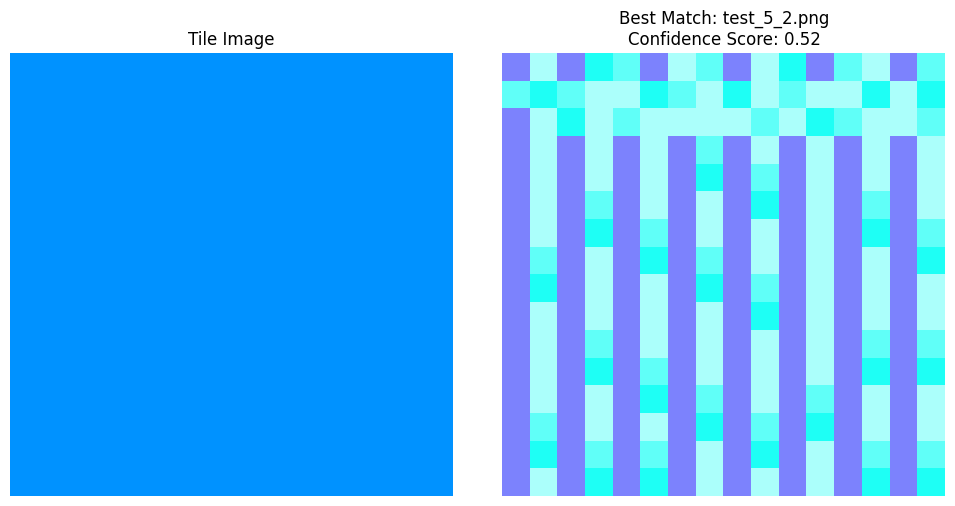

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


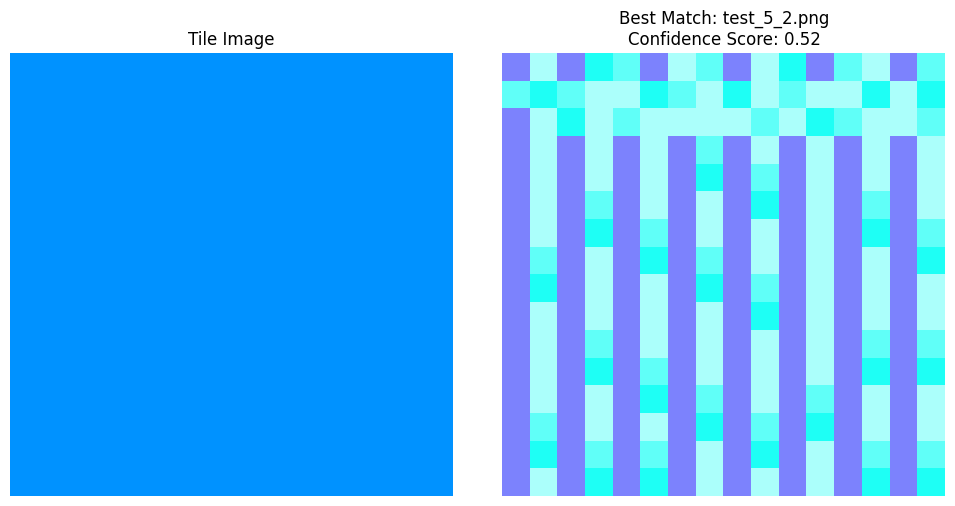

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


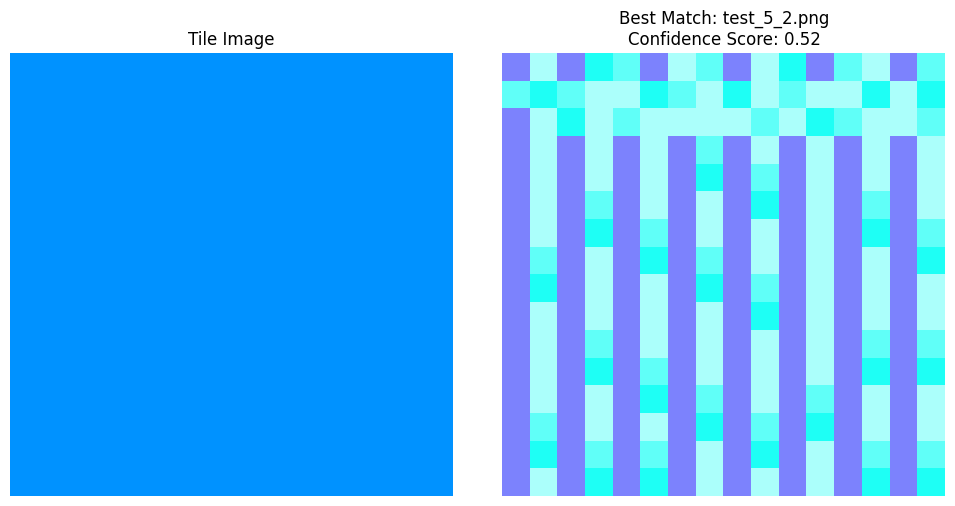

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


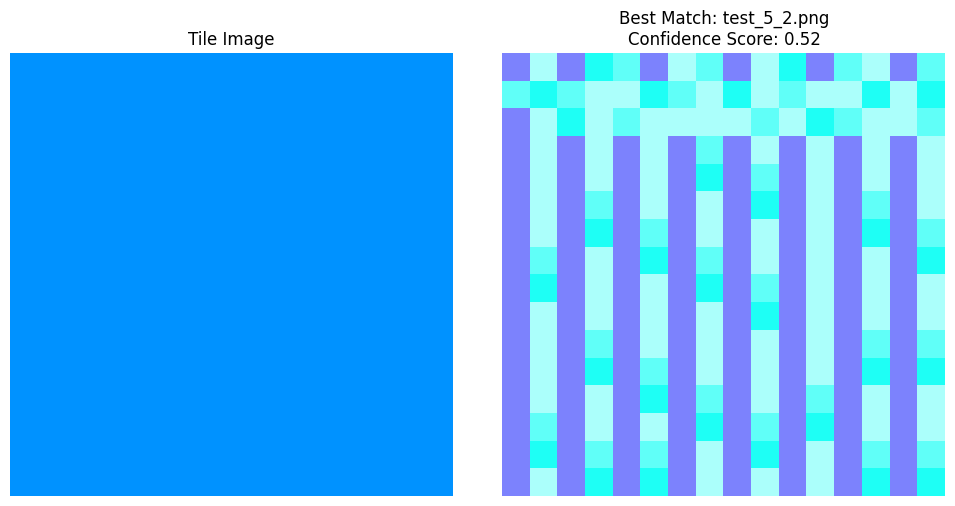

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


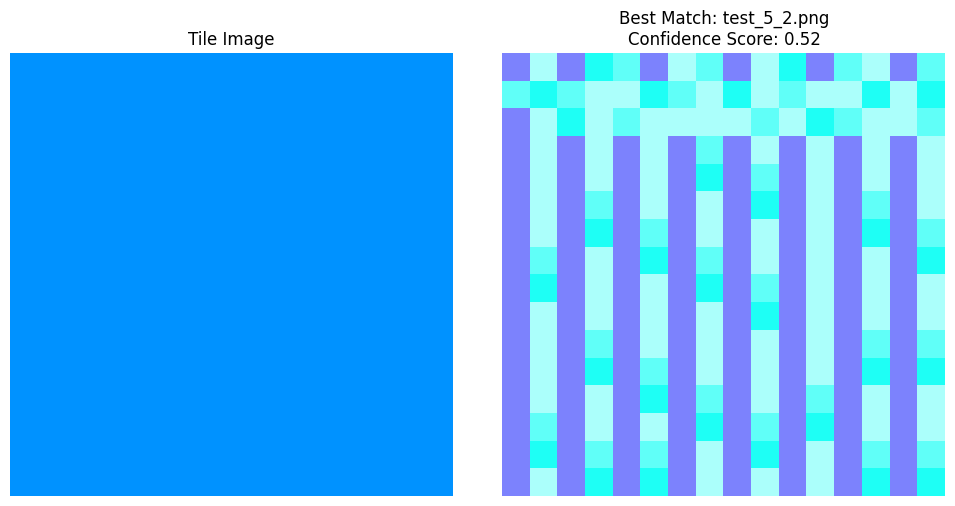

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


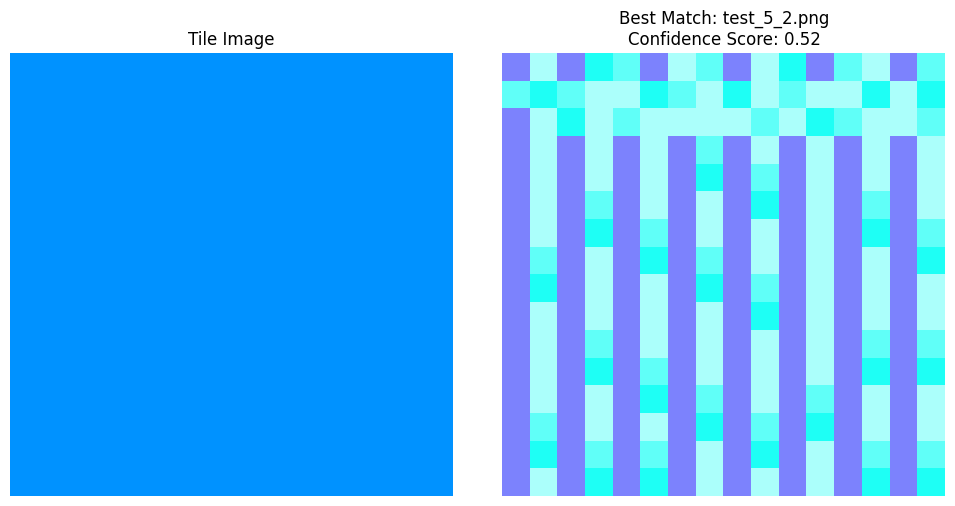

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


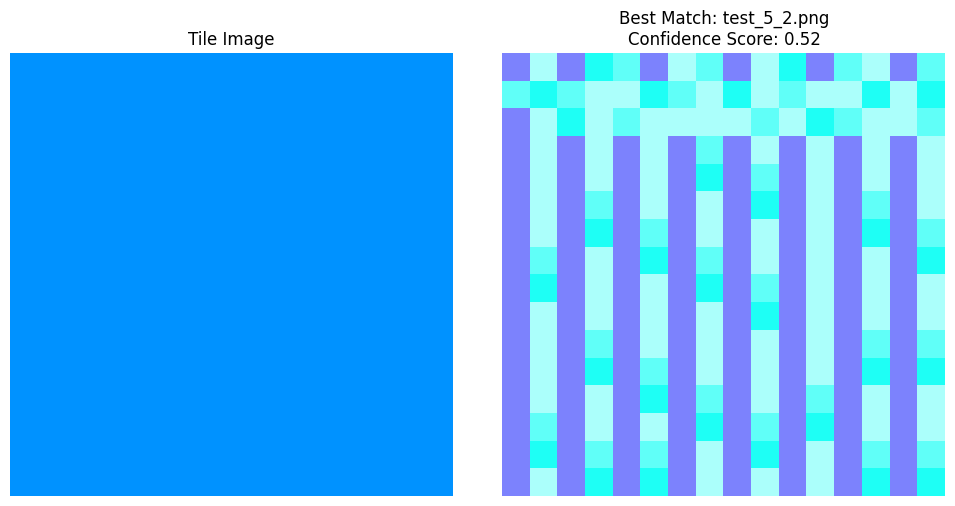

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


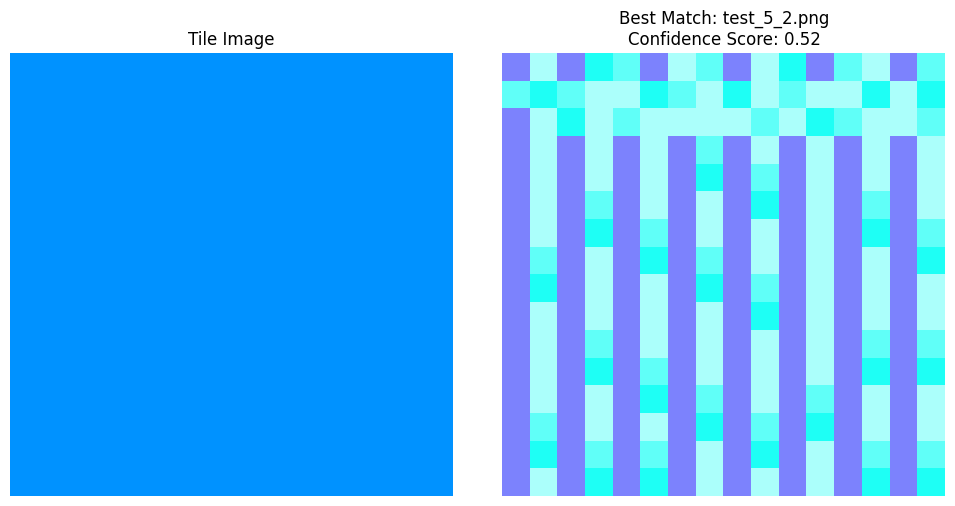

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


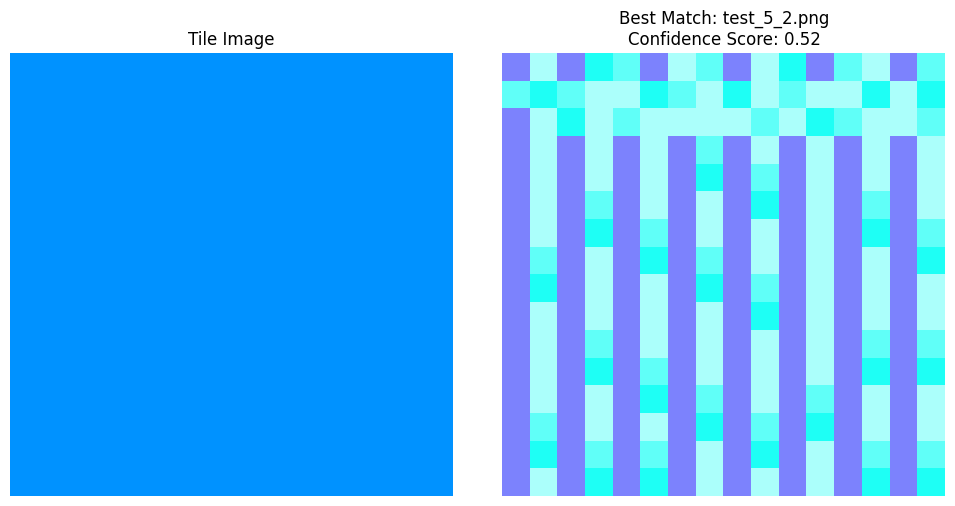

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


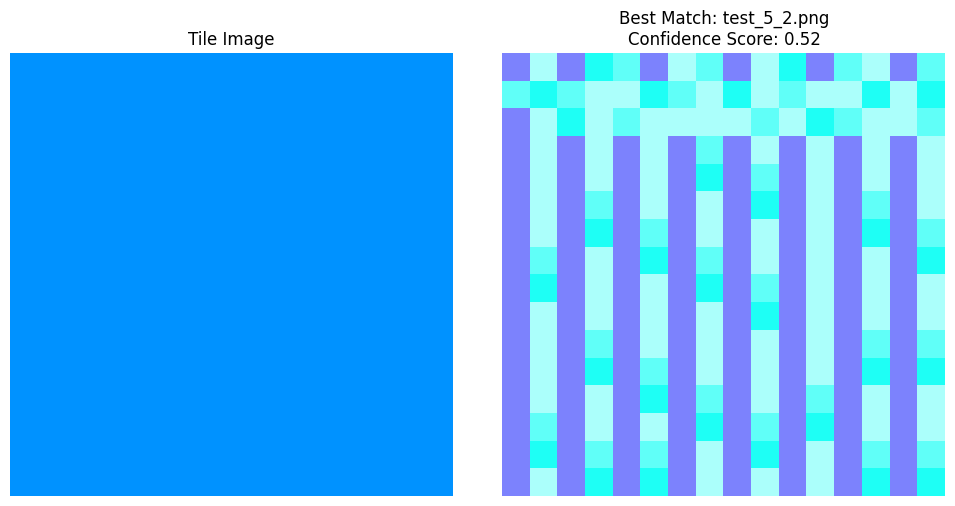

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:
# Perform tile classification and store results
results = []
cpt = 0

for map_folder in os.listdir(tile_dir):
    map_path = os.path.join(tile_dir, map_folder)
    if not os.path.isdir(map_path):
        continue

    for tile_file in os.listdir(map_path):
        tile_path = os.path.join(map_path, tile_file)

        if not tile_file.endswith((".png", ".jpg", ".jpeg")):
            continue

        tile = Image.open(tile_path).convert("RGB")
        tile_preprocessed = preprocess_image(tile)  # Preprocess the tile

        # Predict the tile's class using the CNN model
        tile_input = np.expand_dims(tile_preprocessed, axis=0)  # Add batch dimension
        predictions = model.predict(tile_input)
        predicted_class_idx = np.argmax(
            predictions
        )  # Get the index of the most likely class
        predicted_class = label_encoder.classes_[
            predicted_class_idx
        ]  # Get the sprite name

        # Store the result
        results.append(
            {
                "map_tile": f"{map_folder}/{tile_file}",
                "best_match_sprite": predicted_class,
                "confidence_score": predictions[0][
                    predicted_class_idx
                ],  # Confidence score
            }
        )

        # Display the comparison (Optional, comment out if not needed)
        if cpt < 10:
            show_image_comparison(
                tile,
                f"{predicted_class}.png",
                predictions[0][predicted_class_idx],
                message="Confidence Score",
            )
            cpt += 1

In [ ]:
# Save the results to an Excel file
df_results = pd.DataFrame(results)
df_results.to_excel("cnn_test_matching_results.xlsx", index=False)

It actually works pretty well so as I said I'll use a whole lot of sprite to match the othe possible case of level and it'll as well allow to be more production when the automation part will come.

## 8 - Matching with More Levels color sprites

### a - Cropping 

In [221]:
image_path = "All_stages_mapsheet.png"

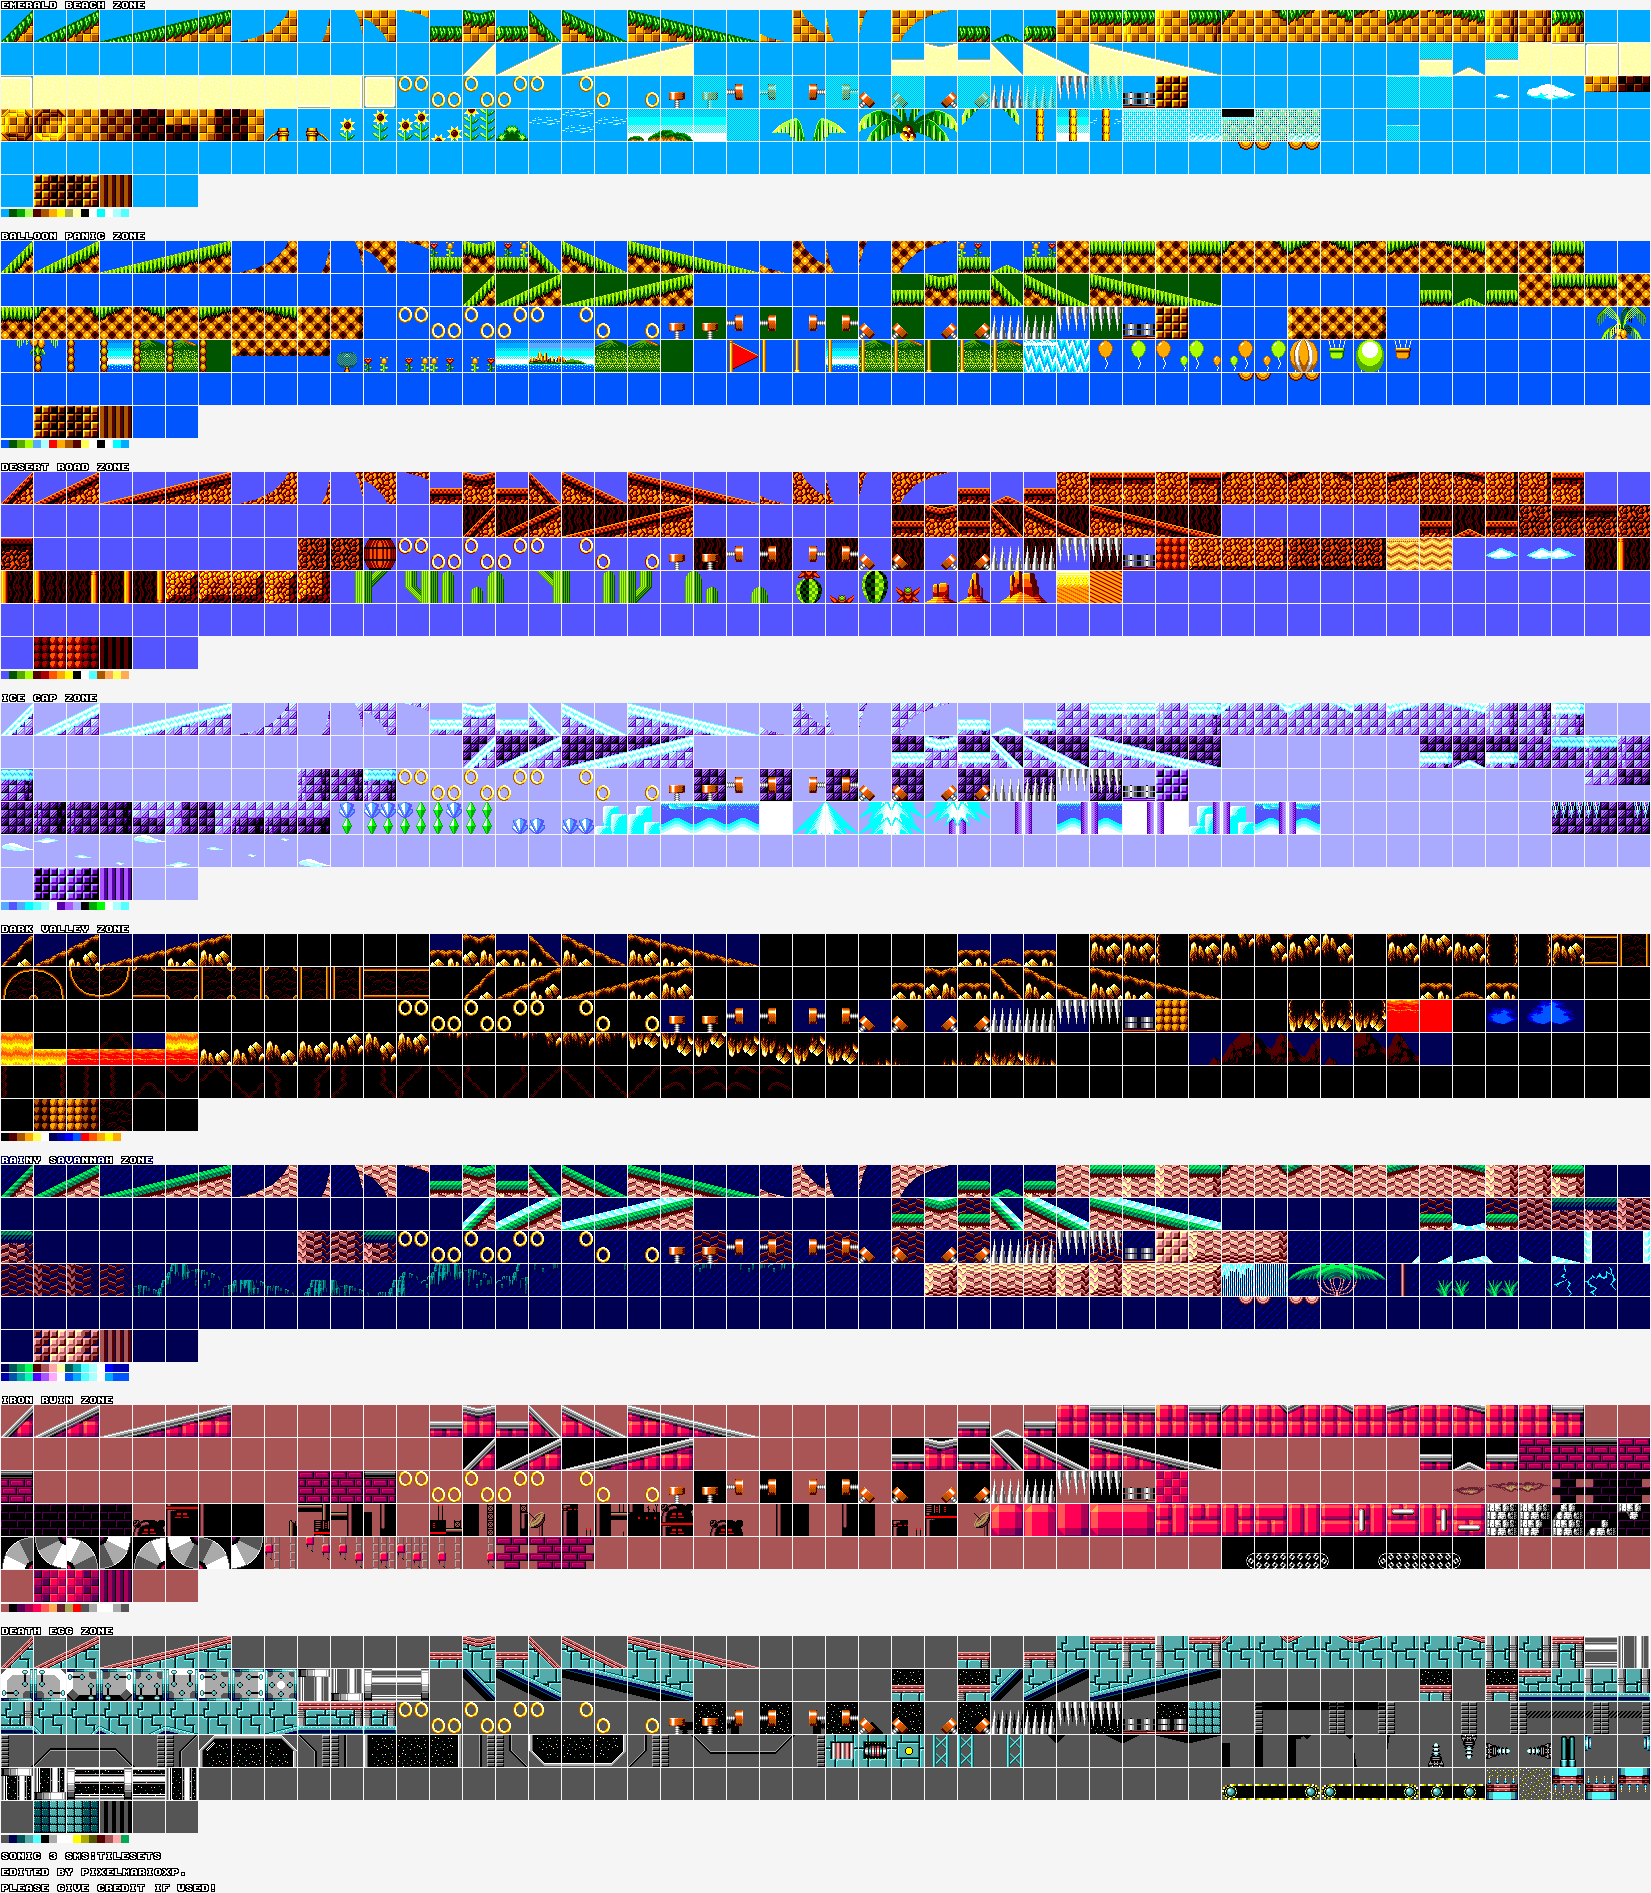

In [222]:
image = Image.open(image_path)
image

In [223]:
image.size

(1651, 1893)

In [224]:
image_width, image_height = image.size

In [225]:
num_y = 6 * 8
num_x = 50

In [226]:
image.crop((0, 0, 32, 10))

In [227]:
object_size = 32
intersect_d = 1
interworld_d = 34 - 1

up_d = 10
left_d = 1

In [228]:
image.crop((left_d, up_d, 32, 32 + up_d))

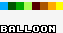

In [229]:
image.crop(
    (
        left_d,
        up_d + 32 * 6 + intersect_d * 5,
        64,
        up_d + 32 * 6 + intersect_d * 5 + interworld_d,
    )
)

In [230]:
### Cropping

for y in range(num_y):
    if y % 7 == 6: # Blank space and unused sprite
        continue

    for x in range(num_x):
        if y % 7 == 5 and x >= 6: # Blank space
            continue  
        
        sprite = image.crop(
            (
                left_d + object_size * x + intersect_d * x,
                up_d + object_size * y + intersect_d * y + (interworld_d * (y // 6)),
                left_d + object_size * (x + 1) + intersect_d * (x),
                up_d
                + object_size * (y + 1)
                + intersect_d * y
                + (interworld_d * (y // 6)),
            )
        )
        sprite.save(f"all_general_map_sprite/sprite_{y}_{x}.png")

### b - Matching

In [201]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

# Load the image
image_path = "Sonic1_MD_Map_Ghz1.png"
image = Image.open(image_path)

# Get image dimensions
width, height = image.size

# Define grid parameters
num_columns = 40
num_rows = 5

# Calculate spacing
col_spacing = width // num_columns
row_spacing = height // num_rows

# Create a drawing context
draw = ImageDraw.Draw(image)

# Draw vertical grid lines (columns)
for i in range(1, num_columns):
    x = i * col_spacing
    draw.line([(x, 0), (x, height)], fill="red", width=1)

# Draw horizontal grid lines (rows)
for j in range(1, num_rows):
    y = j * row_spacing
    draw.line([(0, y), (width, y)], fill="blue", width=1)

# Save the modified image
output_path = "flo.png"
image.save(output_path)
output_path


'flo.png'